## **IMPORTS**

In [1]:
import os
print(f"# --- VERIFICATION DU REPERTOIRE COURANT : {os.getcwd()}")
import sys
# Remonte d'un niveau pour accéder à src/
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# Ajoute src/ au sys.path
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"✅ Chemin ajouté au sys.path : {src_path}")

import os

module_path = os.path.join(src_path, "tags_suggester")
for root, dirs, files in os.walk(module_path):
    for file in files:
        if file.endswith(".py"):
            full_path = os.path.join(root, file)
            with open(full_path, "rb") as f:
                content = f.read()
                if b"\x00" in content:
                    print(f"❌ Caractère nul détecté dans : {full_path}")
                else:
                    print(f"✅ OK : {full_path}")


import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from scipy.stats import entropy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import joblib
import ast
from tags_suggester.preprocessing import text_cleaning
from tags_suggester.preprocessing.text_cleaning import load_tech_terms
print(load_tech_terms())
from tags_suggester.eda.eda_analysis import plot_distribution



# --- VERIFICATION DU REPERTOIRE COURANT : d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\notebooks
✅ Chemin ajouté au sys.path : d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src
✅ OK : d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\__init__.py
✅ OK : d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\api\main.py
✅ OK : d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\api\client\tag_predictor_client.py
✅ OK : d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\api\client\__init__.py
✅ OK : d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\api\routes\predict_routes.py
✅ OK : d:\machine_lea

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'c++', 'mvc 3', 'c#', 'scikit-learn', 'pandas', 'react.js', 'node.js', 'tensorflow', 'asp.net'}



d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


## **1. RECUPERATION DES DONNEES**

### **1.1. EXTRACTION DES DONNEES VIA STACK EXCHANGE DATA EXPLORER**

### **1.2. CHARGEMENT DES DONNEES DANS UN DATAFRAME**

In [2]:
# ---------------------------
# --- CHARGER LE FICHIER CSV
# ---------------------------
full_df = pd.read_csv("../data/raw/stackoverflow_questions_sede.csv")
# -----------------------------------------------
# --- VERIFIER LE NOMBRE DE LIGNES ET UN APERCU
# -----------------------------------------------
print(f"Nombre de questions : {len(full_df)}")

Nombre de questions : 50000


## **2. NETTOYAGE DES DONNEES**

**Objectif : transformer du texte brut en texte propre et exploitable**

### 2.0. PREALABLE

In [3]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES DE NETTOYAGES
# -------------------------------------------
import importlib
import tags_suggester.preprocessing.text_cleaning as tc
importlib.reload(tc)

# -----------------------------------------------------
# --- ETAPE 0. Préparation des sets de mots à exclure
# -----------------------------------------------------
# --- OXFORD TERMS
oxford_terms = tc.extract_oxford_terms(
    path="../src/tags_suggester/config/oxford3000.txt",
    export_cleaned_path="../src/tags_suggester/config/oxford_cleaned.txt",
    verbose=False
)
print(f"Nombre de mots dans oxford_cleaned.txt : {len(oxford_terms)}")
# --- CUSTOM TERMS
stop_terms_custom = tc.load_stop_terms("../src/tags_suggester/config/stop_terms.txt")
# stop_terms_custom = tc.custom_stop_terms
print(f"Nombre de mots dans stop_terms.txt : {len(stop_terms_custom)}")
# --- VAGUE TERMS
vague_path = tc.generate_vague_terms(path="../src/tags_suggester/config/vague_terms.txt", verbose=True)
vague_terms = tc.load_stop_terms(vague_path)
print(f"Nombre de mots dans vague_terms.txt : {len(vague_terms)}")
# --- COMBINAISON DE CE QU'ON VEUT EXCLURE
stopwords_set = tc.combined_stopwords.union(stop_terms_custom).union(oxford_terms).union(vague_terms)
print(f"Nombre de mots exclus : {len(stopwords_set)}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nombre de mots dans oxford_cleaned.txt : 1183
Nombre de mots dans stop_terms.txt : 260
✅ 51 termes vagues enregistrés dans : ../src/tags_suggester/config/vague_terms.txt
Nombre de mots dans vague_terms.txt : 260
Nombre de mots exclus : 1679


### **2.1. APPLICATION SUR UN ECHANTILLON DE 100 QUESTIONS**

In [4]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES DE NETTOYAGES
# -------------------------------------------
import importlib
import tags_suggester.preprocessing.text_cleaning as tc
importlib.reload(tc)



# --------------------------------------------------
# --- ON CONSTRUIT UN ECHANTILLON DE 100 QUESTIONS
# --------------------------------------------------
sample_df = full_df.sample(100, random_state=42).copy()

# ----------------------------------------
# --- NETTOYAGE DES CORPUS TITLE ET BODY
# ----------------------------------------
sample_clean = sample_df.copy()
tqdm.pandas()

sample_clean["clean_title_body"] = (
    sample_df["Title"].fillna("") + " " + sample_df["Body"].fillna("")
).apply(lambda x: tc.clean_text_spacy_custom_2(x, stopwords_set=stopwords_set))
# -------------------------------------------
# --- APERCU DU CORPUS NETTOYÉ
# -------------------------------------------
sample_clean[["PostId", "clean_title_body"]].head(3)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,PostId,clean_title_body
33553,18908639,haskell maps balanced binary tree traditional ...
9427,3735748,measure average thickness trace image number b...
199,389094,dynamic linq join extension dynamic linq exten...


### 2.2. APPLICATION SUR 10 K QUESTIONS


In [5]:
import os
import gc
import importlib
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import tags_suggester.preprocessing.text_cleaning as tc
importlib.reload(tc)

brut_df = full_df.sample(10000, random_state=42).copy()


# 🔸 PARAMÈTRES
chunk_size = 5000
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
output_dir = f"../data/processed/brut_chunks_{timestamp}"
os.makedirs(output_dir, exist_ok=True)  # 📁 création du dossier si absent

# 🔸 CALCUL DU NOMBRE DE CHUNKS
n_chunks = len(brut_df) // chunk_size + int(len(brut_df) % chunk_size > 0)

# 🔸 TRAITEMENT PAR CHUNK
for chunk_index in tqdm(range(n_chunks), desc="Nettoyage & sauvegarde des chunks"):
    start = chunk_index * chunk_size
    end = start + chunk_size
    batch = brut_df.iloc[start:end].copy()

    texts = [
    f"{title} {body}" 
    for title, body in zip(batch["Title"].fillna(""), batch["Body"].fillna(""))
    ]

    # texts = (
    #     title + " " + body
    #     for title, body in zip(batch["Title"].fillna(""), batch["Body"].fillna(""))
    # )
    

    docs = tc.nlp.pipe(texts, batch_size=250, disable=["parser", "ner"])
    batch["clean_title_body"] = [
        tc.clean_doc_spacy_custom(doc, stopwords_set=stopwords_set) for doc in docs
    ]

    # 🔸 SAUVEGARDE DU CHUNK EN .parquet
    chunk_path = os.path.join(output_dir, f"chunk_{chunk_index+1:02}.parquet")
    batch.to_parquet(chunk_path, index=False)
    print(f"💾 Chunk {chunk_index+1}/{n_chunks} sauvegardé → {chunk_path}")

    # 🔸 NETTOYAGE DE MÉMOIRE
    gc.collect()


import glob

files = sorted(glob.glob(os.path.join(output_dir, "chunk_*.parquet")))
print(f"""Les chunks sont assemblés à partir des fichiers du répertoire horodaté :
             {output_dir}""")
brut_df_clean = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

display(brut_df_clean["clean_title_body"].head)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Nettoyage & sauvegarde des chunks:  50%|█████     | 1/2 [03:49<03:49, 229.72s/it]

💾 Chunk 1/2 sauvegardé → ../data/processed/brut_chunks_20250730_1123\chunk_01.parquet


Nettoyage & sauvegarde des chunks: 100%|██████████| 2/2 [06:24<00:00, 192.20s/it]

💾 Chunk 2/2 sauvegardé → ../data/processed/brut_chunks_20250730_1123\chunk_02.parquet
Les chunks sont assemblés à partir des fichiers du répertoire horodaté :
             ../data/processed/brut_chunks_20250730_1123


<bound method NDFrame.head of 0       haskell maps balanced binary tree traditional ...
1       measure average thickness trace image number b...
2       dynamic linq join extension dynamic wiki exten...
3       pre java prettyprint testa tostring args testa...
4       cluster datum pd pd j b j b plot dataframe ind...
                              ...                        
9995    target late android theme late android sdk man...
9996    enable real positioning samsung android browse...
9997    mongodb possible mongo db collection document ...
9998    rail pdf attach render pdf actionmailer attach...
9999    reliable key database linux fast reliable key ...
Name: clean_title_body, Length: 10000, dtype: object>

## **3. EXPLORATION**

### **3.1. APPLICATION SUR UN ECHANTILLON DE 100 QUESTIONS**

#### **3.1.1. FREQUENCE DES MOTS**

,word,frequency
0,time,70
1,size,47
2,kb,36
3,cache,36
4,datum,30


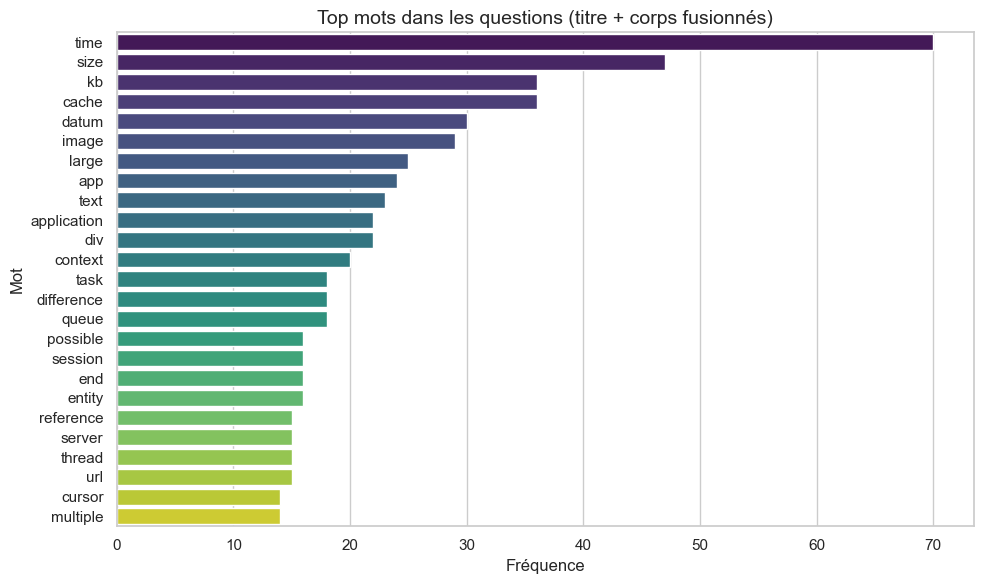

In [6]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# Copie de travail pour toute l’exploration
sample_explo = sample_clean.copy()

# -------------------------------
# --- ANALYSE FREQUENCE DES MOTS
# -------------------------------
freq_title_body = eda.compute_word_frequencies(sample_explo, "clean_title_body", top_n=100)
display(freq_title_body.head())

eda.plot_word_frequencies(
    freq_title_body,
    max_words_display=25,
    palette="viridis",
    title="Top mots dans les questions (titre + corps fusionnés)"
)


#### **3.1.2. NUAGE DE MOTS**

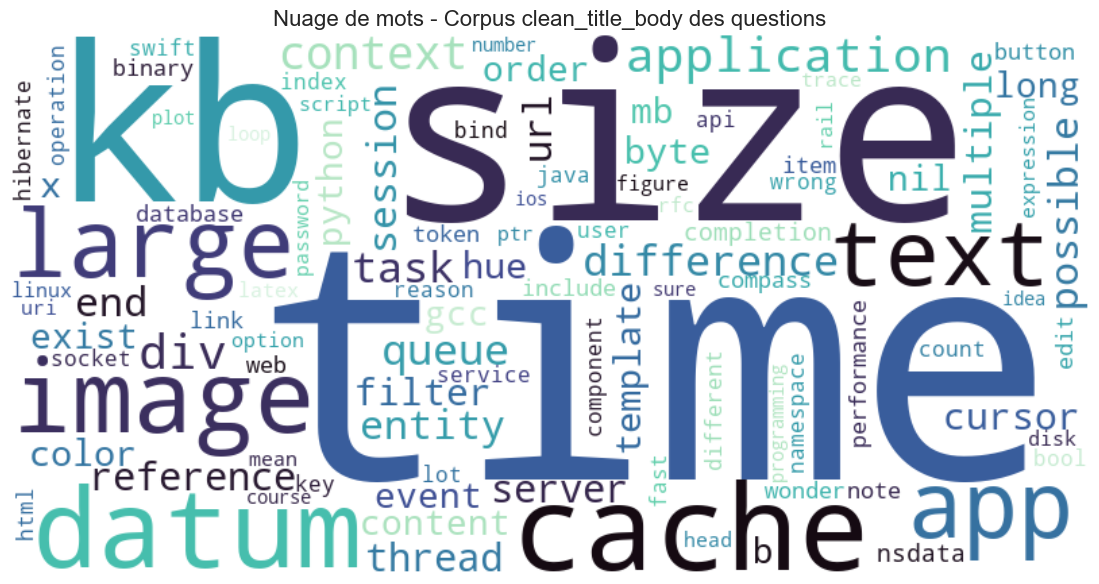

In [7]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)
# -------------------
# --- NUAGE DE MOTS
# -------------------
eda.generate_wordcloud(
    freq_title_body,
     max_words=100,
      colormap="mako",
      title="Nuage de mots - Corpus clean_title_body des questions"
    )

#### **3.1.3. ANALYSE DE LA LONGUEUR DES DOCUMENTS ET DE LA FORME DE SA DISTRIBUTION**

,title_body_length_char,title_body_length_words
count,100.000000,100.000000
mean,339.470000,44.820000
std,523.665393,67.213572
min,48.000000,6.000000
25%,131.500000,18.750000
50%,223.500000,28.500000
75%,334.500000,44.500000
max,4851.000000,598.000000


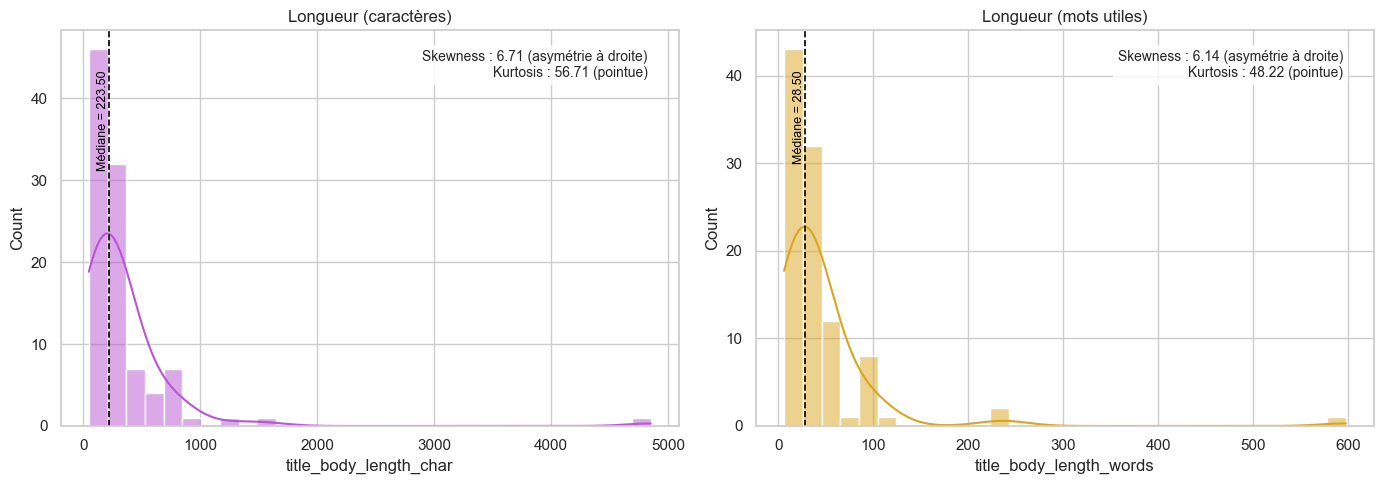

In [8]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)
# -------------------------------
# --- ANALYSE LONGUEUR DU CORPUS FUSIONNÉ
# -------------------------------
sample_explo["title_body_length_char"] = sample_explo["clean_title_body"].str.len()
sample_explo["title_body_length_words"] = sample_explo["clean_title_body"].str.split().apply(len)

# 🧪 Statistiques descriptives
display(sample_explo[["title_body_length_char", "title_body_length_words"]].describe())

# 📊 Visualisation
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

eda.plot_distribution(ax[0], sample_explo["title_body_length_char"], "Longueur (caractères)", "mediumorchid")
eda.plot_distribution(ax[1], sample_explo["title_body_length_words"], "Longueur (mots utiles)", "goldenrod")

plt.tight_layout()
plt.show()


#### **3.1.4. DETECTION DES OUTLIERS ET DOUBLONS**

##### ***3.1.4.1. DÉTECTION DES DOUBLONS EXACTS***

In [9]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# -------------------------------------
# --- DÉTECTION DES DOUBLONS EXACTS
# -------------------------------------

# Nombre total de questions
total_questions = sample_explo.shape[0]

# 🔍 Masque des doublons exacts sur le corpus fusionné nettoyé
duplicate_mask = sample_explo.duplicated(subset=["clean_title_body"], keep=False)
duplicates_df = sample_explo[duplicate_mask]

# 📊 Statistiques sur les doublons
nb_duplicates = duplicates_df.shape[0]
nb_unique_duplicates = duplicates_df.duplicated(subset=["clean_title_body"]).sum()

# 📢 Affichage des résultats
print(f"Nombre total de questions : {total_questions}")
print(f"Nombre de doublons exacts sur 'clean_title_body' : {nb_duplicates}")
print(f"Nombre de doublons à supprimer (copies identiques) : {nb_unique_duplicates}")
print(f"Proportion de doublons dans l’échantillon : {nb_duplicates / total_questions:.2%}")

# 👀 Aperçu des doublons
duplicates_df.sort_values(by="clean_title_body").head(6)[["PostId", "clean_title_body"]]

# 🧹 Suppression des doublons exacts (on garde la première occurrence)
sample_explo = sample_explo.drop_duplicates(subset=["clean_title_body"], keep="first").reset_index(drop=True)


Nombre total de questions : 100
Nombre de doublons exacts sur 'clean_title_body' : 0
Nombre de doublons à supprimer (copies identiques) : 0
Proportion de doublons dans l’échantillon : 0.00%


##### ***3.1.4.2. DÉTECTION DES DOUBLONS FLOUS***

In [10]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# ----------------------------------------------------------
# --- DÉTECTION DE DOUBLONS FLOUS SUR LE CORPUS NETTOYÉ
# ----------------------------------------------------------

# Cosine TF-IDF
fuzzy_cosine = eda.detect_fuzzy_duplicates(sample_explo["clean_title_body"], threshold=0.85)
print(f"# --- Cosine TF-IDF : {len(fuzzy_cosine)} paires similaires détectées (threshold ≥ 0.85)")

# Levenshtein
fuzzy_lev = eda.detect_levenshtein_duplicates(sample_explo["clean_title_body"], threshold=90)
print(f"# --- Levenshtein : {len(fuzzy_lev)} paires similaires détectées (threshold ≥ 90)")

# Jaccard
fuzzy_jaccard = eda.detect_jaccard_duplicates(sample_explo["clean_title_body"], threshold=0.7)
print(f"# --- Jaccard : {len(fuzzy_jaccard)} paires similaires détectées (threshold ≥ 0.7)")


# --- Cosine TF-IDF : 0 paires similaires détectées (threshold ≥ 0.85)
# --- Levenshtein : 0 paires similaires détectées (threshold ≥ 90)
# --- Jaccard : 0 paires similaires détectées (threshold ≥ 0.7)


##### ***3.1.4.4. GESTION DES OUTLIERS***

Outliers détectés par variable :
- title_body_length_words : 12

Nombre total d’outliers (au moins une variable) : 12
Proportion dans l’échantillon : 12.00%
# --- NOMBRE OUTLIERS : 12


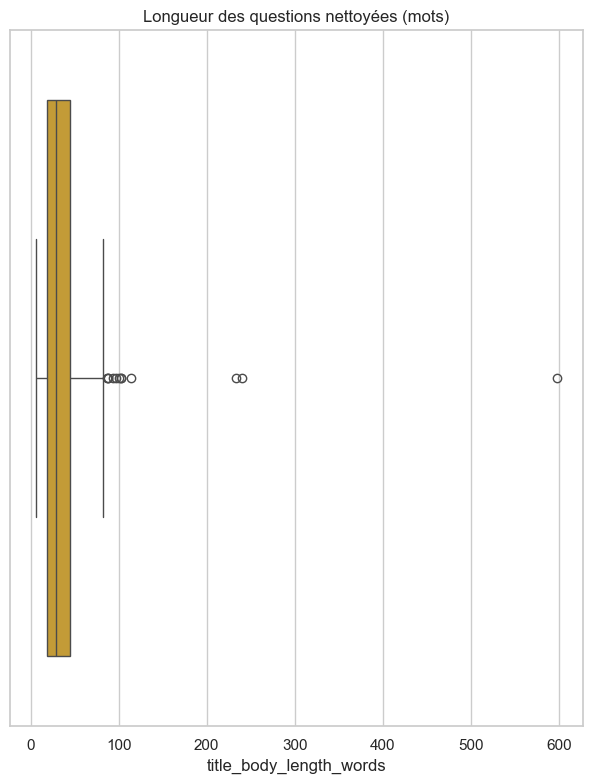

# --- NOMBRE DE QUESTIONS RESTANTES APRES SUPPRESSION DES OUTLIERS : 88


In [11]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# 📏 Création des métriques de longueur
sample_explo["title_body_length_char"] = sample_explo["clean_title_body"].str.len()
sample_explo["title_body_length_words"] = sample_explo["clean_title_body"].str.split().apply(len)

# ---------------------------------------------------------
# --- DETECTION DES OUTLIERS PAR LA METHODE DES SEUILS IQR
# ---------------------------------------------------------
sample_explo, sample_outliers = eda.mark_outliers(
    df=sample_explo,
    columns=["title_body_length_words"],  # ← colonne ciblée
    verbose=True,
    return_outliers=True
)
print(f"# --- NOMBRE OUTLIERS : {sample_outliers.shape[0]}")
# -------------------------------------------
# --- VISUALISATION BOXPLOT DE LA DISPERSION
# -------------------------------------------
eda.plot_boxplots_grid(
    df=sample_explo,
    columns=["title_body_length_words"],
    titles=["Longueur des questions nettoyées (mots)"],
    colors=["goldenrod"]
)

# 🚿 Suppression des outliers
sample_explo_wo = eda.remove_outliers(sample_explo)
print(f"# --- NOMBRE DE QUESTIONS RESTANTES APRES SUPPRESSION DES OUTLIERS : {sample_explo_wo.shape[0]}")


#### **3.1.5. ANALYSE DES TAGS**

##### 3.1.5.1. Structure des tags

In [12]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# -----------------------------
# --- APERCU DE LA COLONNE TAG
# -----------------------------
print(sample_explo_wo["Tags"].head(10))
print(sample_explo_wo["Tags"].apply(type).value_counts())
# ------------------------------------------
# --- CONVERSION DES CHAINES STRING EN LIST
# ------------------------------------------
sample_explo_wo["Tags"] = sample_explo_wo["Tags"].apply(lambda x: x.split(";"))
sample_explo_wo["Tags"].apply(type).value_counts()




0    algorithm;haskell;hashtable;binary-search-tree...
1    language-agnostic;algorithm;image;image-proces...
2    linq;linq-to-objects;linq-to-entities;linq-to-...
3          java;oop;interface;instance;anonymous-class
4    python;matplotlib;seaborn;stacked-bar-chart;gr...
5                          maps;xcode;ios;swift;xcode6
6                 components;maven-2;mojo;plexus;maven
7    javascript;event-driven;frp;reactive-programmi...
8    c++;linker-errors;pure-virtual;vtable;undefine...
9    php;fastcgi;nginx;mod-fastcgi;http-status-code...
Name: Tags, dtype: object
Tags
<class 'str'>    88
Name: count, dtype: int64


Tags
<class 'list'>    88
Name: count, dtype: int64

##### 3.1.5.2. Fréquence des tags  

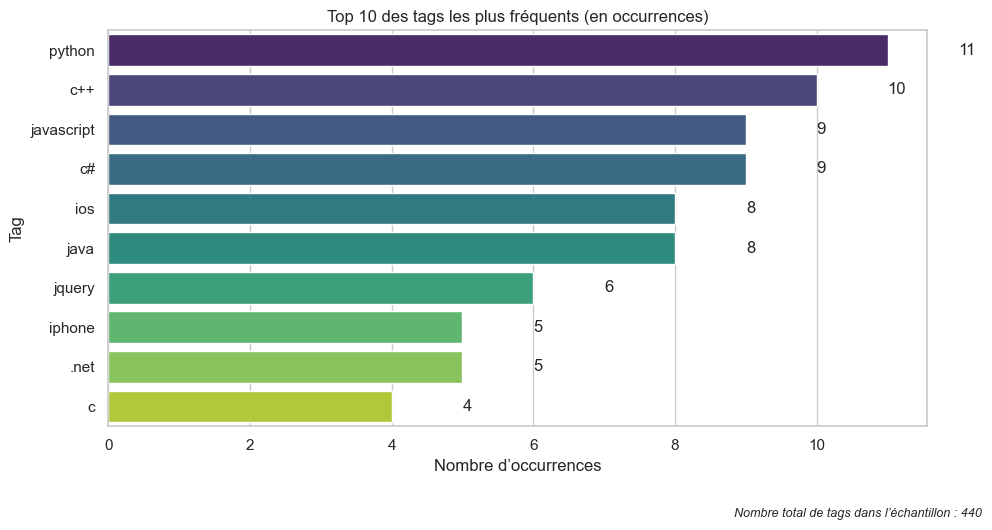

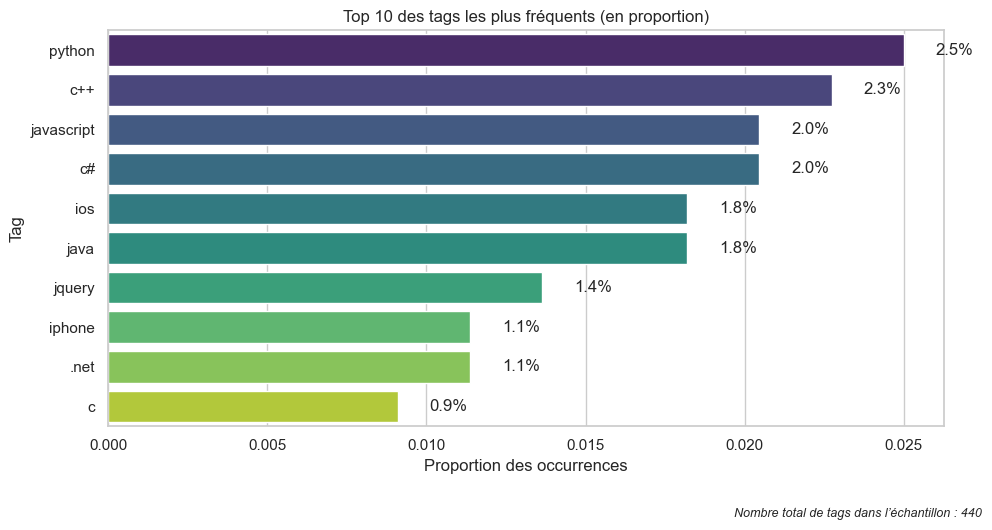

Nombre de tags apparaissant une seule fois : 260


In [13]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)



# --- APLATIR TOUTES LES LISTES DE TAGS
all_tags = [tag for tags in sample_explo_wo["Tags"] for tag in tags]

# --- COMPTER LES OCCURRENCES
tag_counts = Counter(all_tags)

# --- CONVERSION PANDAS POUR VISUALISER
tag_freq_df = pd.DataFrame(tag_counts.items(), columns=["Tag", "Count"]).sort_values(by="Count", ascending=False)
tag_freq_df.reset_index(drop=True, inplace=True)

# --- LES 10 TAGS LES PLUS FREQUENTS
tag_freq_df.head(10)

# --- VISUSALISATION DES TACGS LES PLUS FREQUENTS
eda.plot_tag_occurrences(tag_freq_df, top_n=10)
eda.plot_tag_distribution(tag_freq_df, top_n=10)

# --- TAGS QUI SONT RARES
rare_tags = tag_freq_df[tag_freq_df["Count"] == 1]
print(f"Nombre de tags apparaissant une seule fois : {len(rare_tags)}")

##### 3.1.5.3. Diversité des tags  

Nombre de tags distincts dans l’échantillon : 314


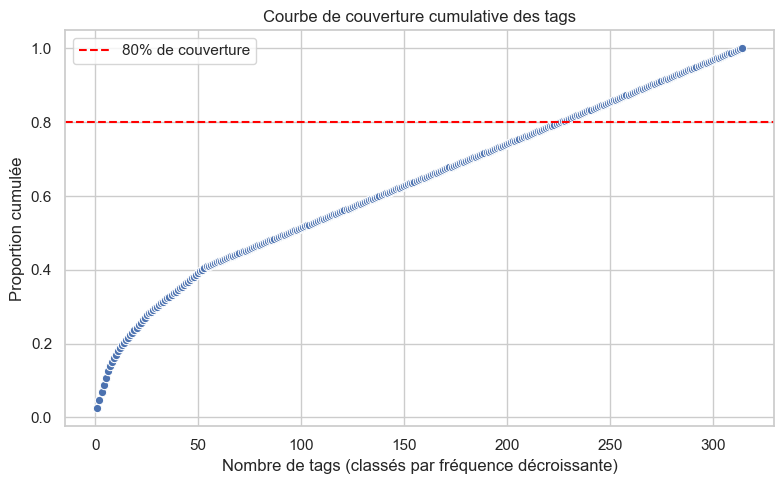

Nombre de tags nécessaires pour couvrir 80% des occurrences : 225
Entropie de la distribution des tags : 7.9657 bits
Entropie maximale possible : 8.2946 bits
Taux de diversité relative : 96.03%


In [14]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# --- NOMBRE DE TAGS DISTINCTS
nb_tags_uniques = tag_freq_df["Tag"].nunique()
print(f"Nombre de tags distincts dans l’échantillon : {nb_tags_uniques}")

# --- CALCUL DE LA PROPORTION CUMULEE
tag_freq_df["Proportion"] = tag_freq_df["Count"] / tag_freq_df["Count"].sum()
tag_freq_df["Cumulative"] = tag_freq_df["Proportion"].cumsum()

# --- VISUALISATION  : COURBE DE COUVERTURE CUMULATIVE
plt.figure(figsize=(8, 5))
sns.lineplot(data=tag_freq_df, x=range(1, len(tag_freq_df)+1), y="Cumulative", marker="o")
plt.axhline(0.8, color="red", linestyle="--", label="80% de couverture")
plt.title("Courbe de couverture cumulative des tags")
plt.xlabel("Nombre de tags (classés par fréquence décroissante)")
plt.ylabel("Proportion cumulée")
plt.legend()
plt.tight_layout()
plt.show()

# --- NOMBRE DE TAGS NECESSAIRE POUR COUVRIR 80% DU CORPUS
nb_tags_80 = (tag_freq_df["Cumulative"] <= 0.8).sum()
print(f"Nombre de tags nécessaires pour couvrir 80% des occurrences : {nb_tags_80}")

# ----------------------------------
# --- CALCUL DE L'ENTROPIE DES TAGS
# ----------------------------------
# --- DISTRIBUTION DES PROPORTIONS
proportions = tag_freq_df["Proportion"].values

# --- ENTROPIE DE SHANNON (BASE 2)
tag_entropy = entropy(proportions, base=2)
print(f"Entropie de la distribution des tags : {tag_entropy:.4f} bits")

# --------------------------------
# --- ENTROPIE MAXIMALE THEORIQUE
# --------------------------------
max_entropy = np.log2(len(proportions))
print(f"Entropie maximale possible : {max_entropy:.4f} bits")
print(f"Taux de diversité relative : {tag_entropy / max_entropy:.2%}")


##### 3.1.5.4. Marquage des tags dominants  


['python',
 'c++',
 'javascript',
 'c#',
 'ios',
 'java',
 'jquery',
 'iphone',
 '.net',
 'c',
 'ruby-on-rails',
 'linux',
 'gcc',
 'objective-c',
 'ruby-on-rails-3',
 'algorithm',
 'xcode',
 'django',
 'performance',
 'dictionary',
 'hibernate',
 'memory-management',
 'html',
 'node.js',
 'image-processing']

,Tag,Count,Proportion,Cumulative,is_dominant_tag
0,python,11,0.025000,0.025000,True
1,c++,10,0.022727,0.047727,True
2,javascript,9,0.020455,0.068182,True
3,c#,9,0.020455,0.088636,True
4,ios,8,0.018182,0.106818,True
5,java,8,0.018182,0.125000,True
6,jquery,6,0.013636,0.138636,True
7,iphone,5,0.011364,0.150000,True
8,.net,5,0.011364,0.161364,True
9,c,4,0.009091,0.170455,True


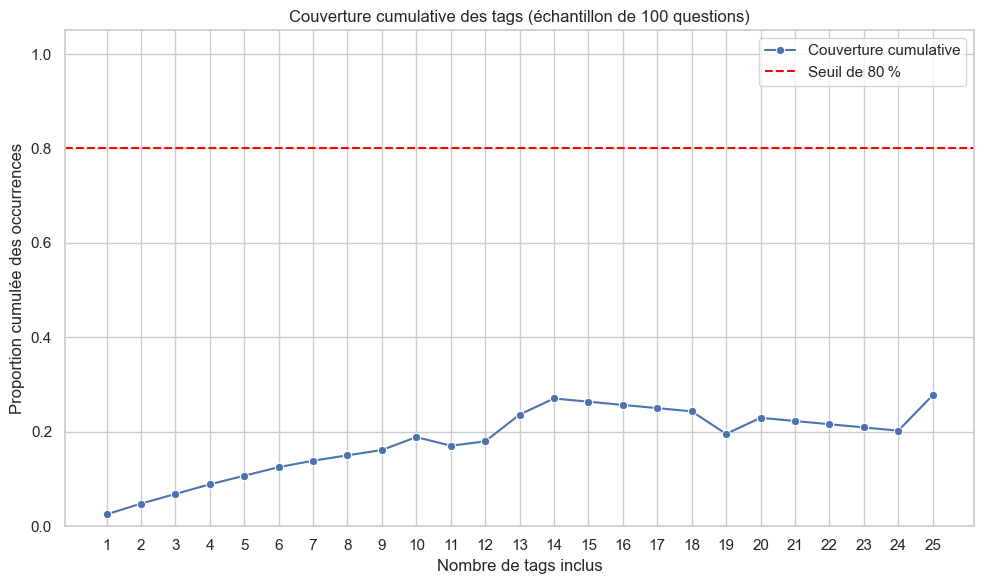

In [15]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# --------------------------------
# --- MARQUAGE DES TAGS DOMINANTS
# --------------------------------
tag_freq_df_marked, dominant_tags = eda.mark_dominant_tags_by_frequency_and_coverage(
    tag_freq_df,
    nb_questions=100,  # ou 50000 plus tard
    min_coverage=0.8,
    min_count_floor=3
)

display(dominant_tags)
display(tag_freq_df_marked)

eda.plot_tag_coverage(tag_freq_df_marked, coverage_target=0.8, title_suffix="échantillon de 100 questions")


#### **3.1.6. CO-OCCURRENCE DES TAGS**

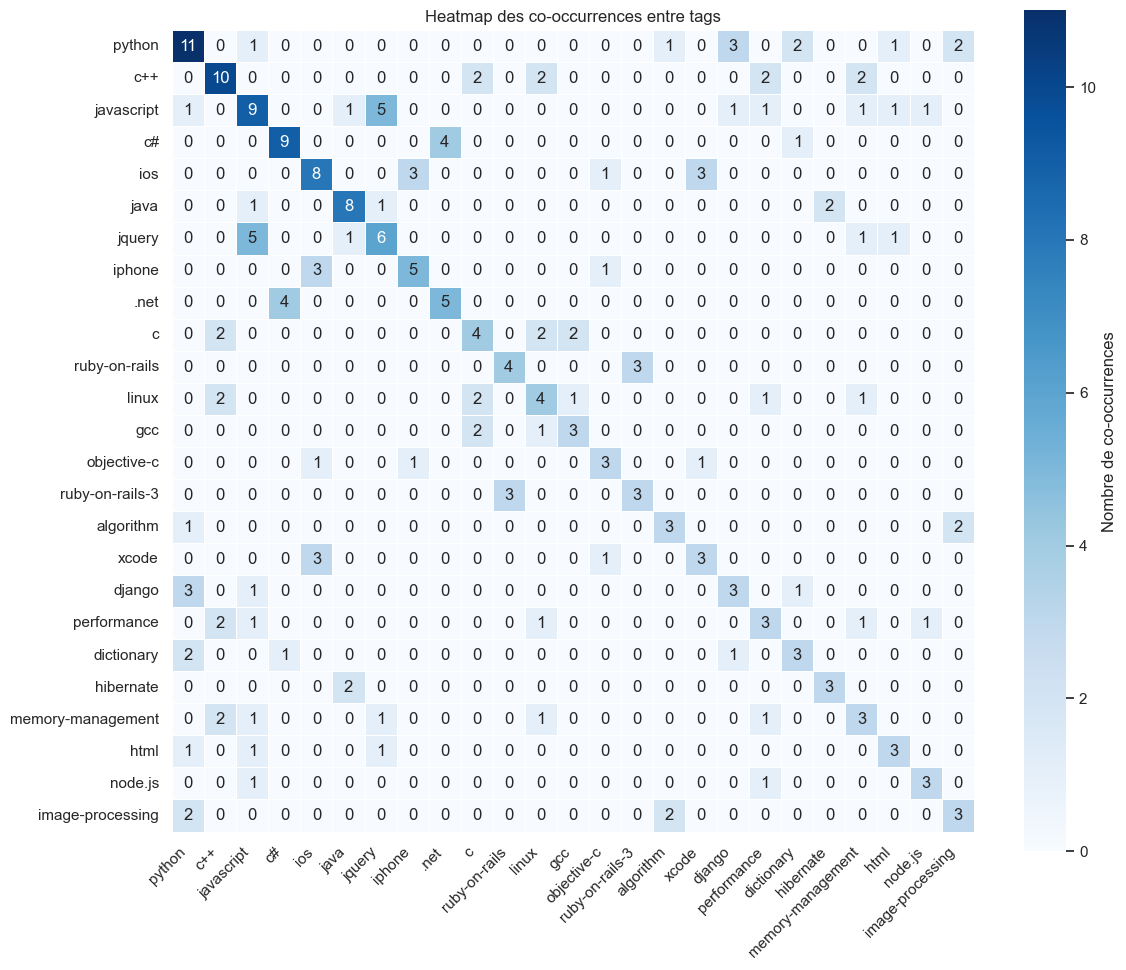

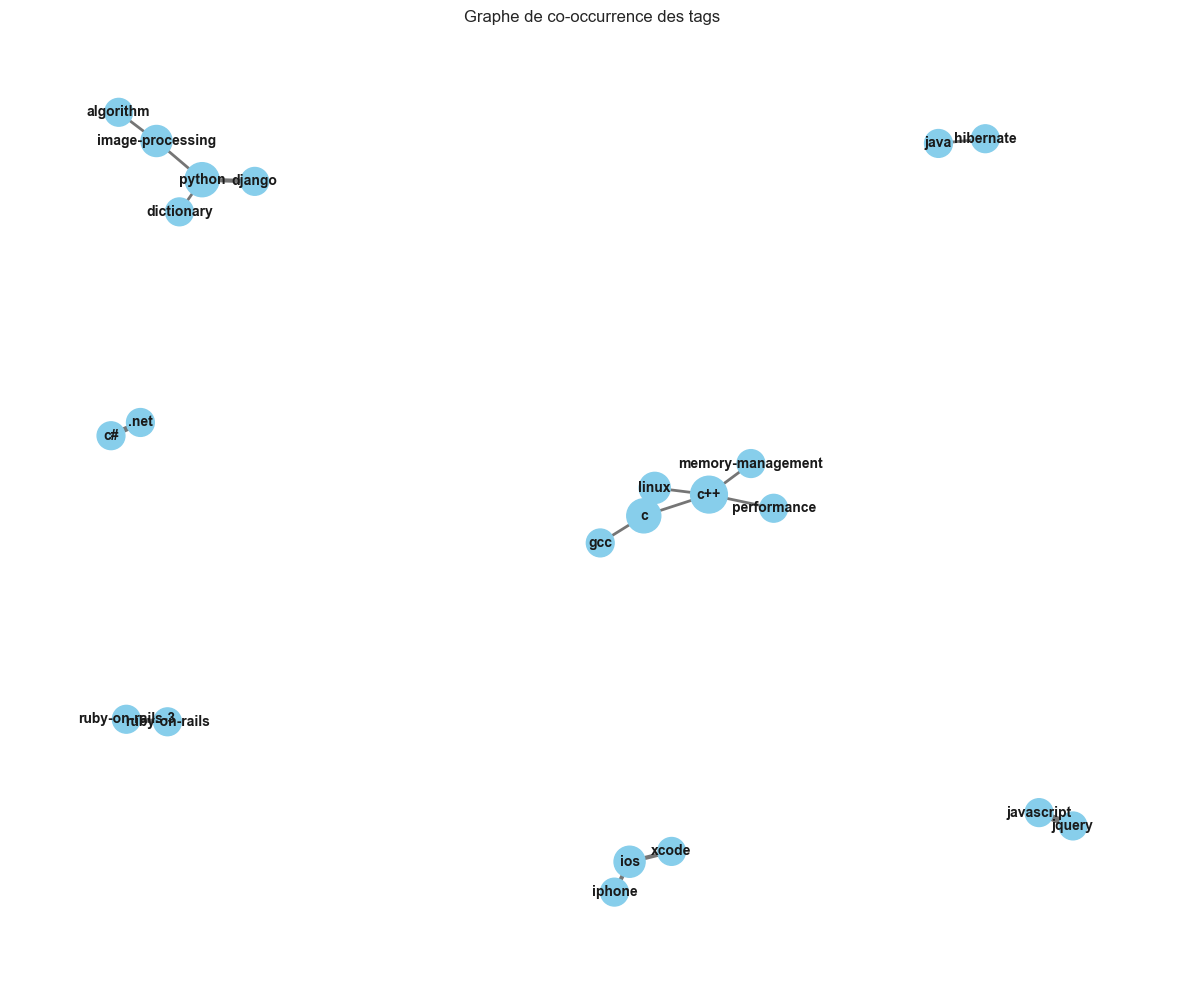

In [16]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

cooc_matrix, tag_matrix = eda.build_tag_cooccurrence_matrix(
    df_questions=sample_explo_wo,  # ou le nom de ton DataFrame
    dominant_tags=dominant_tags,
    tag_col="Tags"
)

cooc_matrix.style.background_gradient(cmap="Blues")

eda.plot_tag_cooccurrence_heatmap(cooc_matrix)

eda.plot_tag_cooccurrence_graph(cooc_matrix, min_edge_weight=2, layout="spring")


### 3.2. APPLICATION SUR 10 K QUESTIONS

#### **3.2.1. FREQUENCE DES MOTS**

,word,frequency
0,android,3312
1,datum,2689
2,user,2593
3,application,2501
4,app,2480
...,...,...
95,current,601
96,window,600
97,site,600
98,cache,595


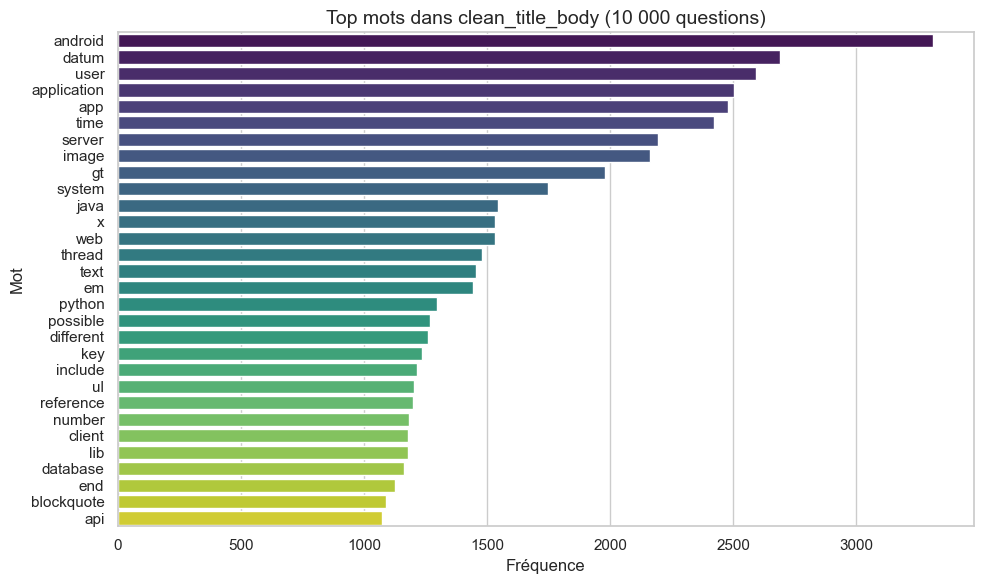

In [17]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# ✅ Standardisation du nom du corpus complet
full_explo = brut_df_clean.copy()


# 🔍 Calcul des fréquences (top 100 lemmes sans les stopwords personnalisés)
freq_clean_title_body = eda.compute_word_frequencies(
    df=full_explo,
    column="clean_title_body",
    top_n=100  # tu peux augmenter selon besoin
)
display(freq_clean_title_body)
# 👁️ Visualisation des top tokens
eda.plot_word_frequencies(
    df_freq=freq_clean_title_body,
    max_words_display=30,
    palette="viridis",
    title="Top mots dans clean_title_body (10 000 questions)"
)



#### **3.2.2. NUAGE DE MOTS**

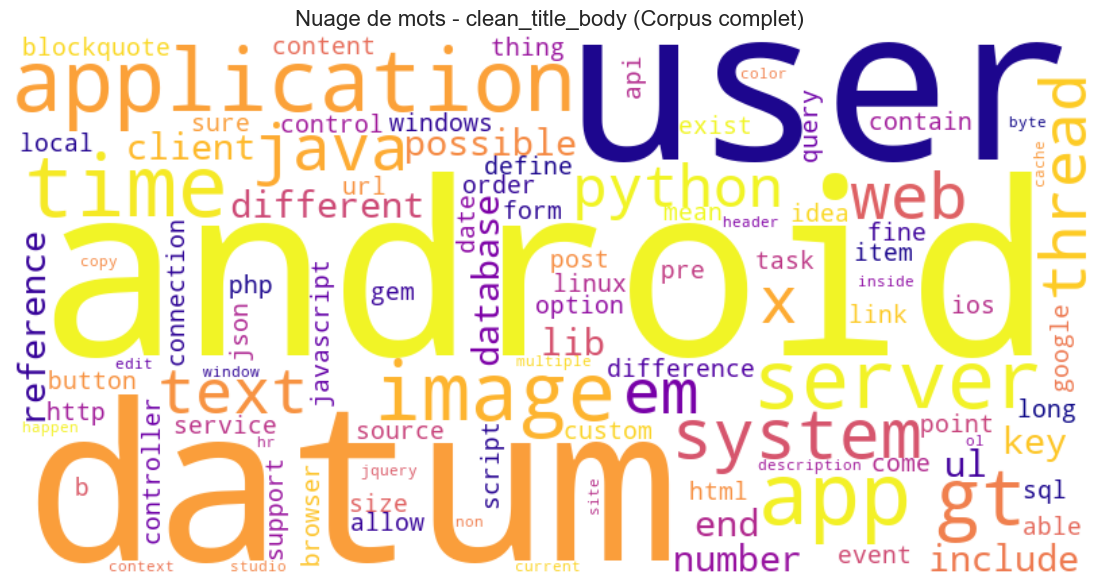

In [18]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

eda.generate_wordcloud(
    df_freq=freq_clean_title_body,
    max_words=100,
    colormap="plasma",
    title="Nuage de mots - clean_title_body (Corpus complet)"
)


#### **3.2.3. ANALYSE DE LA LONGUEUR DES DOCUMENTS ET DE LA FORME DE SA DISTRIBUTION**

Index(['PostId', 'Title', 'Body', 'Score', 'ViewCount', 'AnswerCount',
       'CreationDate', 'TagCount', 'Tags', 'clean_title_body'],
      dtype='object')

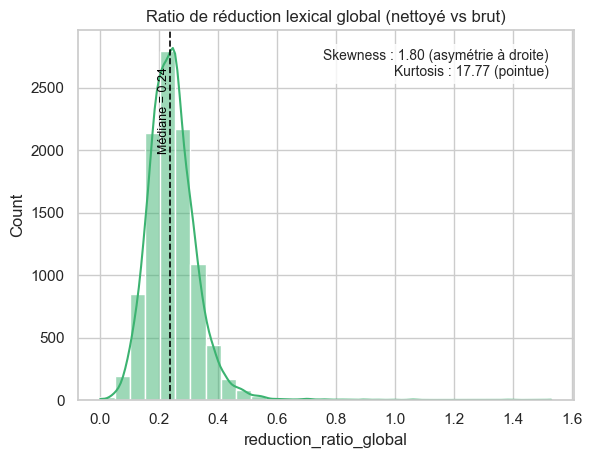

In [19]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

display(full_explo.columns)
# 🔹 Reconstruction du texte brut fusionné
full_explo["title_body_raw"] = full_explo["Title"].fillna("") + " " + full_explo["Body"].fillna("")

# 🔹 Calcul des longueurs en mots
full_explo["length_words_raw"] = full_explo["title_body_raw"].str.split().apply(len)
full_explo["length_words_clean"] = full_explo["clean_title_body"].str.split().apply(len)

# 🔹 Ratio de réduction lexical
full_explo["reduction_ratio_global"] = full_explo["length_words_clean"] / full_explo["length_words_raw"]

eda.plot_distribution(
    ax=plt.gca(),
    data=full_explo["reduction_ratio_global"],
    title="Ratio de réduction lexical global (nettoyé vs brut)",
    color="mediumseagreen"
)


#### **3.2.4. DETECTION DES OUTLIERS ET DOUBLONS**

##### ***3.2.4.1. DÉTECTION DES DOUBLONS EXACTS***

In [20]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# 🔍 Détection des doublons exacts sur le champ nettoyé
exact_dup_mask = full_explo.duplicated(subset=["clean_title_body"], keep=False)
exact_duplicates_df = full_explo[exact_dup_mask]

# 📊 Statistiques
nb_duplicates = exact_duplicates_df.shape[0]
nb_unique = exact_duplicates_df.duplicated(subset=["clean_title_body"]).sum()
total = full_explo.shape[0]

print(f"Nombre total de questions : {total}")
print(f"Nombre de doublons exacts (clean_title_body) : {nb_duplicates}")
print(f"Nombre de doublons à supprimer (copies identiques) : {nb_unique}")
print(f"Proportion de doublons dans le corpus : {nb_duplicates / total:.2%}")

# 💬 Affichage de quelques doublons
exact_duplicates_df.sort_values("clean_title_body").head(6)[["PostId", "clean_title_body"]]

# 🧹 Suppression des doublons exacts (on garde la première occurrence)
full_explo = full_explo.drop_duplicates(subset=["clean_title_body"], keep="first").reset_index(drop=True)
display(exact_duplicates_df)

Nombre total de questions : 10000
Nombre de doublons exacts (clean_title_body) : 5
Nombre de doublons à supprimer (copies identiques) : 4
Proportion de doublons dans le corpus : 0.05%


,PostId,Title,Body,Score,ViewCount,AnswerCount,CreationDate,TagCount,Tags,clean_title_body,title_body_raw,length_words_raw,length_words_clean,reduction_ratio_global
4397,8757389,Reading a file line by line in Go,<p>I'm unable to find <code>file.ReadLine</cod...,583,653852,13,2012-01-06 11:50:24,5,string;parsing;file;line;go,,Reading a file line by line in Go <p>I'm unabl...,25,0,0.0
5099,3533774,VB.NET: Get class name of a instance,<p>Is there a way to get the instance's class ...,25,41763,4,2010-08-20 18:29:07,5,.net;vb.net;oop;class;instance,,VB.NET: Get class name of a instance <p>Is the...,19,0,0.0
5923,11202673,Converting string to float in C#,"<p>I am converting a string like ""41.000273576...",141,763001,9,2012-06-26 07:35:01,5,.net;c#;string;floating-point;type-conversion,,Converting string to float in C# <p>I am conve...,40,0,0.0
6681,4691699,How to convert .crt to .pem,<p>How can I convert .crt to .pem?</p>\n,367,1124293,2,2011-01-14 13:49:40,5,asn.1;crt;pem;x509;der,,How to convert .crt to .pem <p>How can I conve...,13,0,0.0
9867,2344411,How to convert string to integer in C#,<p>How do I convert a string to an integer in ...,101,243765,12,2010-02-26 19:57:19,5,.net;c#;string;int;type-conversion,,How to convert string to integer in C# <p>How ...,19,0,0.0


In [21]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

<module 'tags_suggester.eda.eda_analysis' from 'D:\\machine_learning_training\\openclassrooms_projects\\05_categorisez_automatiquement_question\\src\\tags_suggester\\eda\\eda_analysis.py'>

##### ***3.2.4.3. GESTION DES OUTLIERS***

In [22]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)


full_explo, full_outliers = eda.mark_outliers(
    df=full_explo,
    columns=[
        "length_words_clean",
        "reduction_ratio_global"
    ],
    verbose=True,
    return_outliers=True
)

# eda.plot_boxplots_grid(
#     df=full_explo,
#     columns=[
#         "length_words_clean",
#         "reduction_ratio_global"
#     ],
#     titles=[
#         "Longueur nettoyée - titre + body",
#         "Ratio de réduction lexical"
#     ],
#     colors=["steelblue", "mediumseagreen"]
# )
full_explo_wo = eda.remove_outliers(full_explo)
print(f"# ✅ Questions restantes après suppression des outliers : {full_explo_wo.shape[0]}")


Outliers détectés par variable :
- length_words_clean : 762
- reduction_ratio_global : 215

Nombre total d’outliers (au moins une variable) : 905
Proportion dans l’échantillon : 9.05%
# ✅ Questions restantes après suppression des outliers : 9091


#### **3.2.5. ANALYSE DES TAGS**

##### 3.2.5.1. Structure des tags

In [23]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# --- APERCU DE LA COLONNE TAGS
print(full_explo_wo["Tags"].head(10))
print(full_explo_wo["Tags"].apply(type).value_counts())
# --- CONVERSION DES CHAINES EN LISTES
full_explo_wo["Tags"] = full_explo_wo["Tags"].apply(lambda x: x.split(";") if isinstance(x, str) else [])
# --- VERIFICATION POST CONVERSION
print(full_explo_wo["Tags"].apply(type).value_counts())


0    algorithm;haskell;hashtable;binary-search-tree...
1    language-agnostic;algorithm;image;image-proces...
2    linq;linq-to-objects;linq-to-entities;linq-to-...
3          java;oop;interface;instance;anonymous-class
4    python;matplotlib;seaborn;stacked-bar-chart;gr...
5                          maps;xcode;ios;swift;xcode6
6                 components;maven-2;mojo;plexus;maven
7    javascript;event-driven;frp;reactive-programmi...
8    c++;linker-errors;pure-virtual;vtable;undefine...
9    php;fastcgi;nginx;mod-fastcgi;http-status-code...
Name: Tags, dtype: object
Tags
<class 'str'>    9091
Name: count, dtype: int64
Tags
<class 'list'>    9091
Name: count, dtype: int64


##### 3.2.5.2. Fréquence des tags  

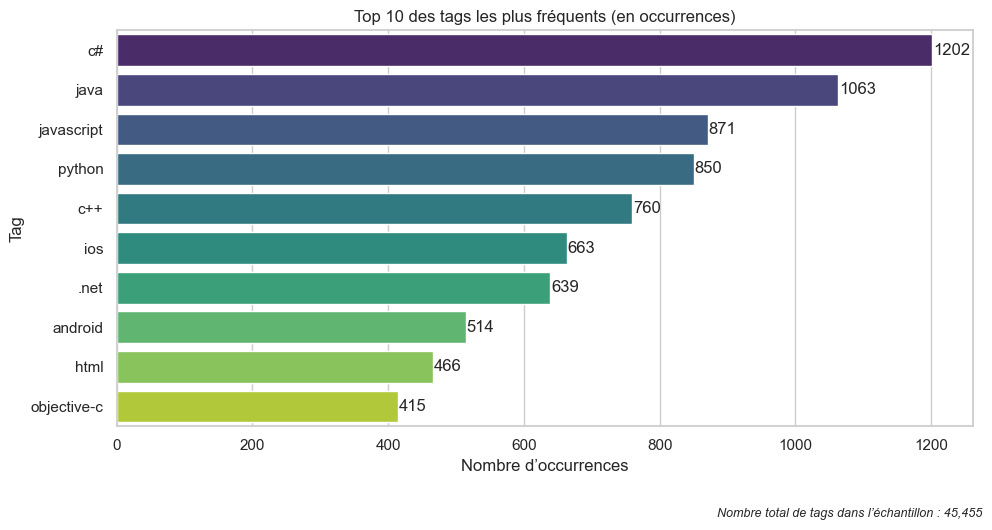

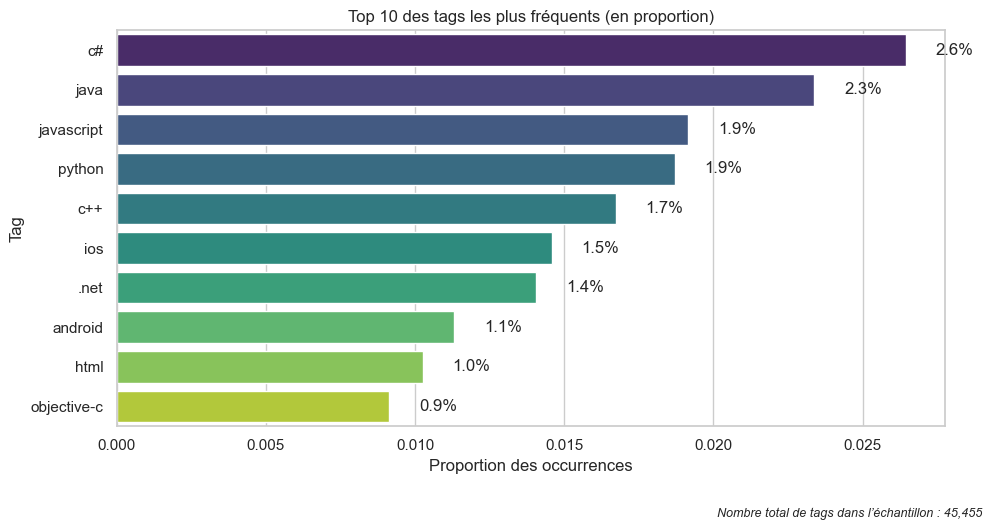

Nombre de tags apparaissant une seule fois : 3638


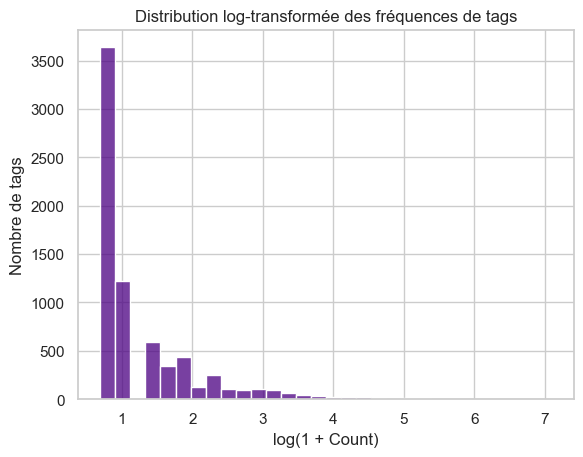

In [24]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# --- ON APLATIT LA LISTE DES TAGS
from collections import Counter

all_tags = [tag for tags in full_explo_wo["Tags"] for tag in tags]

# --- ON COMPTE LES OCCURRENCES
tag_counts = Counter(all_tags)
# --- CONVERSION EN PANDAS DATAFRAME POUR VISUALISATION
tag_freq_df = pd.DataFrame(tag_counts.items(), columns=["Tag", "Count"]).sort_values(by="Count", ascending=False)
tag_freq_df.reset_index(drop=True, inplace=True)
# ---AFFICHAGE DES TAGS LES PLUS FREQUENTS
tag_freq_df.head(10)
# --- VISUALISATION
eda.plot_tag_occurrences(tag_freq_df, top_n=10)
eda.plot_tag_distribution(tag_freq_df, top_n=10)
# --- EXTRACTION DES TAGS RARES
rare_tags = tag_freq_df[tag_freq_df["Count"] == 1]
print(f"Nombre de tags apparaissant une seule fois : {len(rare_tags)}")
# --- DISTRIBUTION DES TAGS PAR FREQUENCE
tag_freq_df["log_count"] = np.log1p(tag_freq_df["Count"])
sns.histplot(tag_freq_df["log_count"], bins=30, color="indigo")
plt.title("Distribution log-transformée des fréquences de tags")
plt.xlabel("log(1 + Count)")
plt.ylabel("Nombre de tags")
plt.show()

# --- 

##### 3.2.5.3. Diversité des tags  

Nombre de tags distincts dans le corpus : 7259


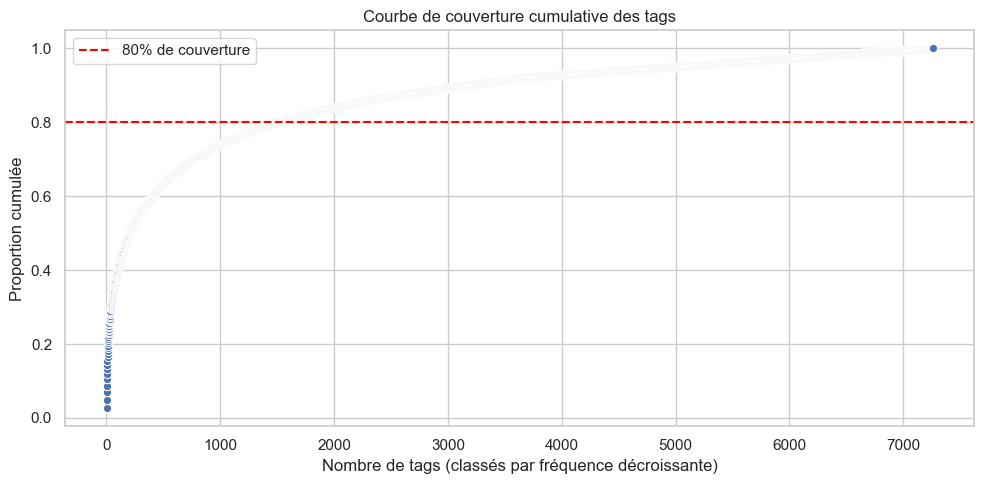

Nombre de tags nécessaires pour couvrir 80 % des occurrences : 1501
Entropie de la distribution des tags : 10.3984 bits
Entropie maximale possible : 12.8256 bits
Taux de diversité relative : 81.08%


In [25]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# --- NOMBRE DE TAGS UNIQUES
nb_tags_uniques = tag_freq_df["Tag"].nunique()
print(f"Nombre de tags distincts dans le corpus : {nb_tags_uniques}")
# --- CALCUL DE LA PROPORTION CUMULEE
tag_freq_df["Proportion"] = tag_freq_df["Count"] / tag_freq_df["Count"].sum()
tag_freq_df["Cumulative"] = tag_freq_df["Proportion"].cumsum()
# --- VISUALISATION DE COUVERTURE CUMULATIVE
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=tag_freq_df,
    x=range(1, len(tag_freq_df) + 1),
    y="Cumulative",
    marker="o"
)
plt.axhline(0.8, color="red", linestyle="--", label="80% de couverture")
plt.title("Courbe de couverture cumulative des tags")
plt.xlabel("Nombre de tags (classés par fréquence décroissante)")
plt.ylabel("Proportion cumulée")
plt.legend()
plt.tight_layout()
plt.show()


# --- NOMBRE DE TAGS NECESSAIRES POUR COUVRIR 80% DES OCCURRENCES
nb_tags_80 = (tag_freq_df["Cumulative"] <= 0.8).sum()
print(f"Nombre de tags nécessaires pour couvrir 80 % des occurrences : {nb_tags_80}")
# --- ENTROPIE DE LA DISTRIBUTION DES TAGS (SHANNON BASE 2)
from scipy.stats import entropy

proportions = tag_freq_df["Proportion"].values
tag_entropy = entropy(proportions, base=2)
print(f"Entropie de la distribution des tags : {tag_entropy:.4f} bits")

max_entropy = np.log2(len(proportions))
print(f"Entropie maximale possible : {max_entropy:.4f} bits")
print(f"Taux de diversité relative : {tag_entropy / max_entropy:.2%}")



##### 3.2.5.4. Marquage des tags dominants  

['c#',
 'java',
 'javascript',
 'python',
 'c++',
 'ios',
 '.net',
 'android',
 'html',
 'objective-c',
 'jquery',
 'iphone',
 'php',
 'c',
 'sql',
 'linux',
 'css',
 'asp.net',
 'xcode',
 'ruby-on-rails',
 'string',
 'arrays',
 'performance',
 'json',
 'asp.net-mvc',
 'c++11',
 'windows',
 'database',
 'sql-server',
 'mysql',
 'node.js',
 'wpf',
 'multithreading',
 'spring',
 'ruby',
 'algorithm',
 'django',
 'unit-testing',
 'bash',
 'swift',
 'cocoa-touch',
 'visual-studio',
 'macos',
 'git',
 'shell',
 'image',
 'ajax',
 'postgresql',
 'debugging',
 'angularjs',
 'eclipse',
 'gcc',
 'google-chrome',
 'hibernate',
 'numpy',
 'rest',
 'pandas',
 'list',
 'unix',
 'xaml',
 'entity-framework',
 'class',
 'security',
 'linq',
 'exception',
 'ipad',
 'http',
 'xml',
 'jpa',
 'ubuntu',
 'twitter-bootstrap',
 'regex',
 'function',
 'r',
 'testing',
 'file',
 'apache',
 'winforms',
 'python-3.x',
 'dictionary',
 'maven',
 'unicode',
 't-sql',
 'logging',
 'oop',
 'date',
 'python-2.7',
 'fo

,Tag,Count,log_count,Proportion,Cumulative,is_dominant_tag
0,c#,1202,7.092574,0.026444,0.026444,True
1,java,1063,6.969791,0.023386,0.049830,True
2,javascript,871,6.770789,0.019162,0.068991,True
3,python,850,6.746412,0.018700,0.087691,True
4,c++,760,6.634633,0.016720,0.104411,True
...,...,...,...,...,...,...
787,char,9,2.302585,0.000198,0.704389,True
788,dispose,9,2.302585,0.000198,0.704587,True
789,overflow,9,2.302585,0.000198,0.704785,True
790,in-app-purchase,9,2.302585,0.000198,0.704983,True


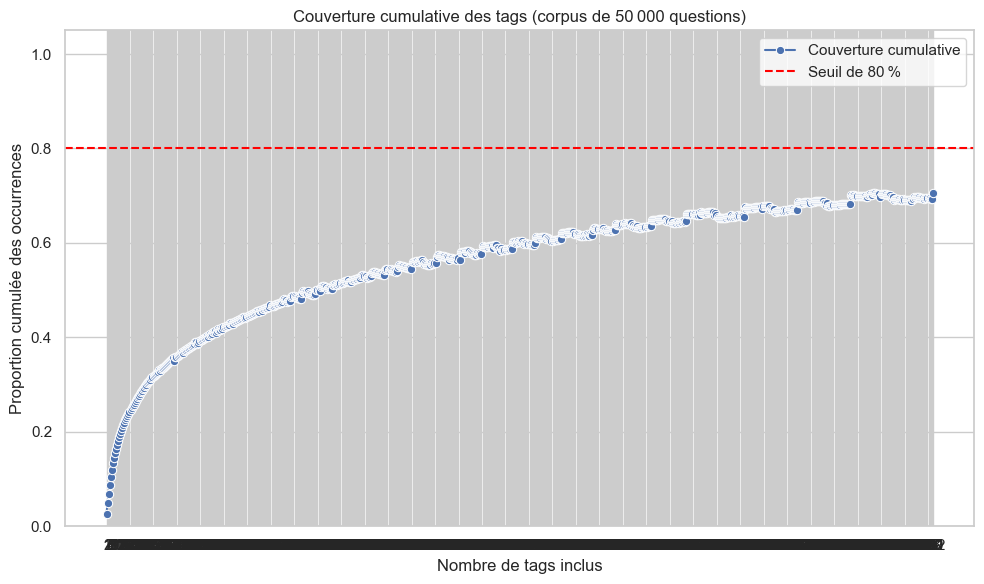

In [26]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)


# ✅ Marquage des tags dominants sur le corpus complet
tag_freq_df_marked, dominant_tags = eda.mark_dominant_tags_by_frequency_and_coverage(
    tag_freq_df=tag_freq_df,
    nb_questions=full_explo_wo.shape[0],  # 50 000 ou autre taille réelle
    min_coverage=0.8,
    min_count_floor=3
)

# 👁️ Affichage des tags dominants
display(dominant_tags)
display(tag_freq_df_marked)

# 📊 Visualisation de la couverture cumulative
eda.plot_tag_coverage(
    tag_freq_df_marked,
    coverage_target=0.8,
    title_suffix="corpus de 50 000 questions"
)


#### **3.2.6. CO-OCCURRENCE DES TAGS**

In [27]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# # --- CONSTRUCTION DES MATRICES
# cooc_matrix, tag_matrix = eda.build_tag_cooccurrence_matrix(
#     df_questions=full_explo_wo,
#     dominant_tags=dominant_tags,
#     tag_col="Tags"
# )
# # --- HEATMAP DES CO OCCURRENCES
# cooc_matrix.style.background_gradient(cmap="Blues")

# eda.plot_tag_cooccurrence_heatmap(cooc_matrix)
# # --- GRAPHE DE CO OCCURRENCE VISUEL
# eda.plot_tag_cooccurrence_graph(
#     cooc_matrix,
#     min_edge_weight=2,           # pour éviter les arêtes anecdotiques
#     layout="spring"              # layout fluide et lisible
# )



<module 'tags_suggester.eda.eda_analysis' from 'D:\\machine_learning_training\\openclassrooms_projects\\05_categorisez_automatiquement_question\\src\\tags_suggester\\eda\\eda_analysis.py'>

## **4. FEATURE ENGINEERING**  

### **4.1. APPLICATION SUR UN ECHANTILLON DE 100 QUESTIONS**

#### **4.1.1. VECTORISATION TF-IDF**

Shape de la matrice TF-IDF (title + body) : (88, 269)
Top 15 mots (title + body) par poids TF-IDF :
image: 3.75
time: 3.16
python: 2.99
difference: 2.82
app: 2.67
text: 2.30
wonder: 2.24
exist: 2.14
index: 2.09
hibernate: 2.08
key: 2.07
application: 2.05
linux: 2.03
cursor: 2.00
size: 1.96


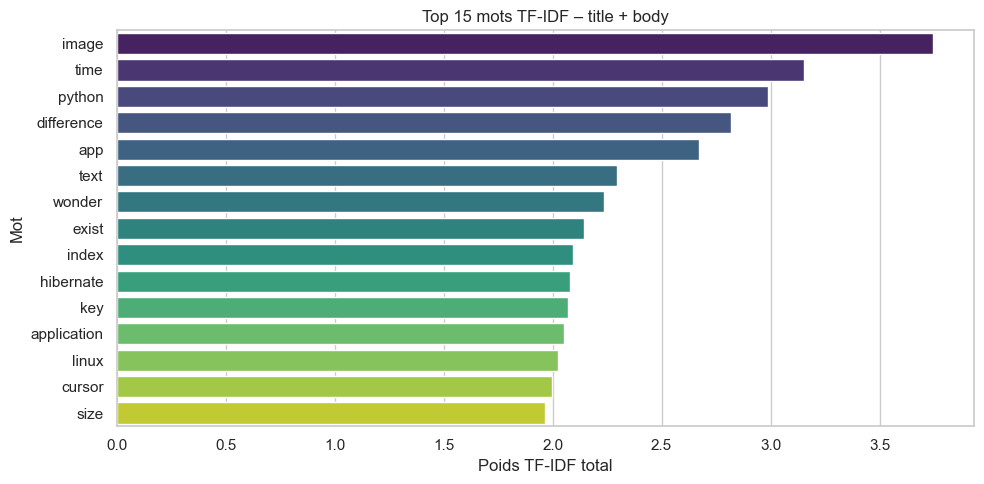

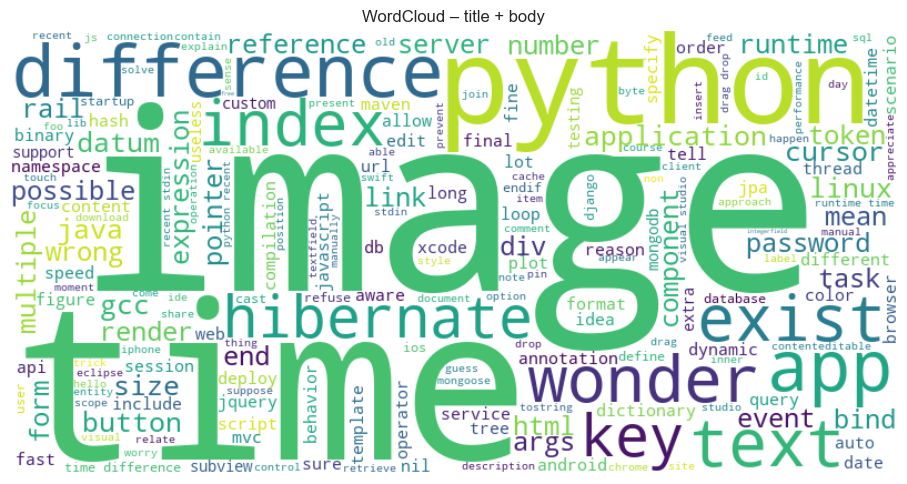

,word,score
0,image,3.745980
1,time,3.155452
2,python,2.986851
3,difference,2.820468
4,app,2.669918
5,text,2.297525
6,wonder,2.236579
7,exist,2.144265
8,index,2.093526
9,hibernate,2.078922


Dimensions du X_titlebody_tfidf : (88, 269)


In [28]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# --------------------------------------
# --- VECTORISATION DU CORPUS FUSIONNÉ
# --------------------------------------
X_titlebody_tfidf, titlebody_vocab, top_titlebody_words = eda.vectorize_tfidf(
    sample_explo_wo["clean_title_body"],
    label="title + body"
)

# 📊 Aperçu des termes les plus fréquents
top_titlebody_words_df = pd.DataFrame(top_titlebody_words, columns=["word", "score"])
display(top_titlebody_words_df.head(10))

# 🔍 Shape du matrice TF-IDF
print(f"Dimensions du X_titlebody_tfidf : {X_titlebody_tfidf.shape}")
from scipy.sparse import save_npz
save_npz("models/tfidf/X_tfidf_sample.npz", X_titlebody_tfidf)
import pickle
with open("models/tfidf/vocab_tfidf_sample.pkl", "wb") as f:
    pickle.dump(titlebody_vocab, f)
with open("models/tfidf/corpus_sample.pkl", "wb") as f:
    pickle.dump(sample_explo_wo["clean_title_body"].tolist(), f)

with open("models/tfidf/top_titlebody_words.pkl", "wb") as f:
    pickle.dump(top_titlebody_words, f)

#### **4.1.2. REDUCTION DE DIMENSION (SVD, PCA)**

Explained variance (title + body) : 3.92%


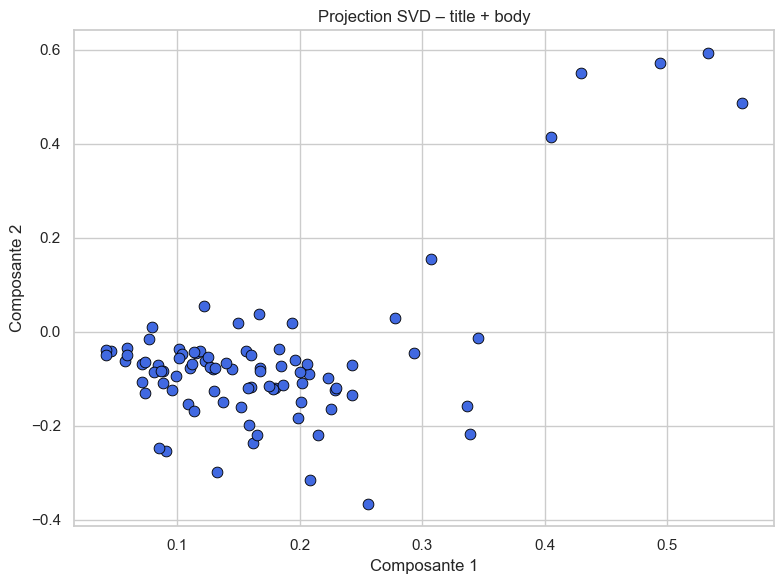

Variance expliquée cumulée (title + body) :
 - 10 composantes : 23.44%
 - 20 composantes : 42.50%
 - 50 composantes : 80.48%


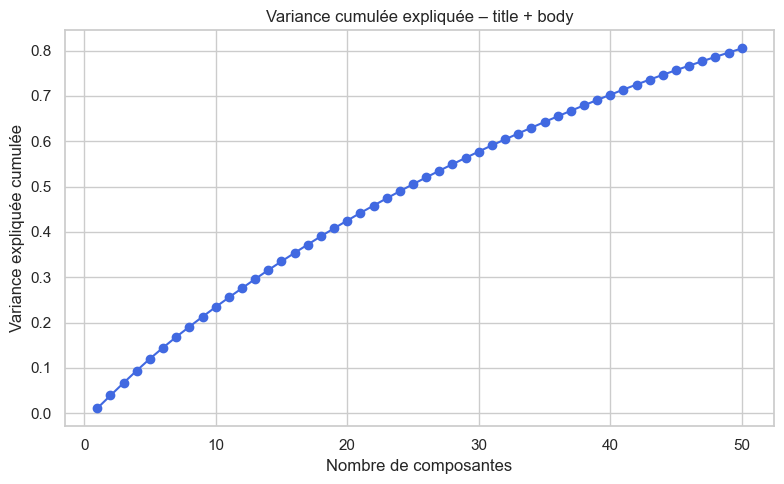

In [29]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# ----------------------------------------------
# --- REDUCTION DIMENSIONS SVD DU CORPUS FUSIONNÉ
# ----------------------------------------------
# --- Reduction en 2D pour visualisation
X_titlebody_svd, svd_titlebody = eda.apply_svd_and_plot(X_titlebody_tfidf, label="title + body")


# --- Réduction à n dimensions avec suivi de la variance cumulée
X_titlebody_svd100, svd_titlebody100 = eda.apply_svd_variance(X_titlebody_tfidf, label="title + body", n_components=50)
np.save("models/svd/X_titlebody_svd_100.npy", X_titlebody_svd100)
import pickle
with open("models/svd/svd_model_100.pkl", "wb") as f:
    pickle.dump(svd_titlebody100, f)


#### **4.1.3. EMBEDDINGS**

##### 4.1.3.1. METHODE SBERT

In [30]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

corpus_titlebody = sample_explo_wo["clean_title_body"].fillna("").tolist()
embeddings_sbert = eda.encode_sbert_corpus(corpus_titlebody, batch_size=32)
print(f"✅ SBERT Embeddings shape : {embeddings_sbert.shape}")
np.save("models/sbert/embeddings_sbert.npy", embeddings_sbert)


🔄 Chargement du modèle SBERT...
✅ SBERT chargé : all-MiniLM-L6-v2
➡️ Batch 0 à 32 encodé
➡️ Batch 32 à 64 encodé
➡️ Batch 64 à 88 encodé
✅ SBERT Embeddings shape : (88, 384)


##### 4.1.3.2. METHODE WORD2VEC

In [31]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

from gensim.models import Word2Vec


corpus_titlebody = sample_explo_wo["clean_title_body"].fillna("").tolist()

model_w2v = eda.train_word2vec(
    corpus=corpus_titlebody,
    save_path="models/word2vec/word2vec_titlebody.bin",  # dossier à créer si nécessaire
    vector_size=100,
    window=5,
    min_count=3,
    epochs=10,
    verbose=True
)

# 🔁 Vectorisation du corpus complet
w2v_model_sample = Word2Vec.load("models/word2vec/word2vec_titlebody.bin")
corpus_sample = sample_explo_wo["clean_title_body"].fillna("").tolist()
X_w2v_sample = eda.vectorize_texts(corpus_sample, w2v_model_sample)

# 💾 Sauvegarde
np.save("models/word2vec/X_w2v_sample.npy", X_w2v_sample)


INFO - 2025-07-30 11:32:15,566 - collecting all words and their counts
INFO - 2025-07-30 11:32:15,567 - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2025-07-30 11:32:15,570 - collected 1078 word types from a corpus of 2539 raw words and 88 sentences
INFO - 2025-07-30 11:32:15,570 - Creating a fresh vocabulary
INFO - 2025-07-30 11:32:15,570 - Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 290 unique words (26.90% of original 1078, drops 788)', 'datetime': '2025-07-30T11:32:15.570125', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
INFO - 2025-07-30 11:32:15,570 - Word2Vec lifecycle event {'msg': 'effective_min_count=3 leaves 1526 word corpus (60.10% of original 2539, drops 1013)', 'datetime': '2025-07-30T11:32:15.570125', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1

🔄 Préparation du corpus...
🧠 Corpus prêt avec 88 documents.


INFO - 2025-07-30 11:32:15,715 - Word2Vec lifecycle event {'update': False, 'trim_rule': 'None', 'datetime': '2025-07-30T11:32:15.715916', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'build_vocab'}
INFO - 2025-07-30 11:32:15,715 - Word2Vec lifecycle event {'msg': 'training model with 1 workers on 290 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2025-07-30T11:32:15.715916', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'train'}
INFO - 2025-07-30 11:32:15,801 - EPOCH 0: training on 2539 raw words (1129 effective words) took 0.1s, 14121 effective words/s
INFO - 2025-07-30 11:32:15,832 - EPOCH 1: training on 2539 raw words (1189 effective words) took 0.0s, 174681 effective words/s
INFO - 202

💾 Modèle sauvegardé dans d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\notebooks\models\word2vec\word2vec_titlebody.bin


##### 4.1.3.3. METHODE UNIVERSAL SENTENCE ENCODER (USE)

In [32]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)


corpus_titlebody = sample_explo_wo["clean_title_body"].fillna("").tolist()

embeddings_use = eda.encode_use_corpus(corpus_titlebody, batch_size=100)
print(f"✅ USE Embeddings shape : {embeddings_use.shape}")
np.save("models/use_model/embeddings_use.npy", embeddings_use)

WARNING - 2025-07-30 11:32:20,765 - From d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\tensorflow_hub\resolver.py:498: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.



WARNING - 2025-07-30 11:32:21,082 - From d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\tensorflow_hub\module_v2.py:126: The name tf.saved_model.load_v2 is deprecated. Please use tf.compat.v2.saved_model.load instead.

INFO - 2025-07-30 11:33:54,547 - Fingerprint not found. Saved model loading will continue.
INFO - 2025-07-30 11:33:54,766 - path_and_singleprint metric could not be logged. Saved model loading will continue.


✅ USE chargé depuis : C:\Users\hp\.cache\kagglehub\models\google\universal-sentence-encoder\tensorFlow2\universal-sentence-encoder\2
🔄 Batch 0 → 88 encodé
✅ USE Embeddings shape : (88, 512)


#### **4.1.4. VECTORISATION BoW (CountVectorizer)**

In [33]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

corpus_bow, X_bow, vocab_bow = eda.build_bow_matrix(
    df=sample_explo_wo,
    col_title="clean_title_body",  # ✅ corpus fusionné
    col_body="clean_title_body",  # ✅ encore le même
    max_df=0.9,
    min_df=5,
    stop_words="english"
)

print("# --- Matrice BoW:", X_bow.shape)
print("# --- Taille du vocabulaire:", len(vocab_bow))
import scipy.sparse
scipy.sparse.save_npz("models/bow/X_bow.npz", X_bow)
import pickle
with open("models/bow/corpus_bow.pkl", "wb") as f:
    pickle.dump(corpus_bow, f)
with open("models/bow/vocab_bow.pkl", "wb") as f:
    pickle.dump(vocab_bow, f)

# --- Matrice BoW: (88, 38)
# --- Taille du vocabulaire: 38


#### **4.1.5. ENCODAGE DES TAGS (MULTI-LABEL BINARIZER)**

# --- ON AFFICHE LES TAGS ENCODES


,.net,.net-4.0,64-bit,addsubview,algorithm,android,angularjs,anonymous-class,arrays,asp.net-4.0,...,vtable,web-services,wget,where-clause,windows,wpf,xcode,xcode5,xcode6,zeus
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
84,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# --- ON AFFICHE LA FUSION DES TAGS ENCODES AVEC LE DATAFRAME sample_explo_wo : 


,PostId,Title,Body,Score,ViewCount,AnswerCount,CreationDate,TagCount,Tags,clean_title_body,...,vtable,web-services,wget,where-clause,windows,wpf,xcode,xcode5,xcode6,zeus
0,18908639,Why are Haskell Maps implemented as balanced b...,"<p>From my limited knowledge of Haskell, it se...",21,2798,4,2013-09-20 04:06:07,5,"[algorithm, haskell, hashtable, binary-search-...",haskell maps balanced binary tree traditional ...,...,0,0,0,0,0,0,0,0,0,0
1,3735748,Measuring the average thickness of traces in a...,<p>Here's the problem: I have a number of bina...,19,6026,7,2010-09-17 13:33:43,5,"[language-agnostic, algorithm, image, image-pr...",measure average thickness trace image number b...,...,0,0,0,0,0,0,0,0,0,0
2,389094,How to create a dynamic LINQ join extension me...,"<p>There was a library of dynamic <a href=""htt...",16,34299,3,2008-12-23 15:12:34,5,"[linq, linq-to-objects, linq-to-entities, linq...",dynamic linq join extension dynamic linq exten...,...,0,0,0,0,0,0,0,0,0,0
3,4000062,Can we create an object of an interface?,"<pre class=""lang-java prettyprint-override""><c...",33,46647,6,2010-10-22 19:01:14,5,"[java, oop, interface, instance, anonymous-class]",testa tostring args testa tostring runtime com...,...,0,0,0,0,0,0,0,0,0,0
4,22787209,How to have clusters of stacked bars,<p>So here is how my data set looks like :</p>...,90,90737,10,2014-04-01 13:22:11,5,"[python, matplotlib, seaborn, stacked-bar-char...",cluster datum pd pd j b j b plot dataframe ind...,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,12656648,UICollectionView Performing Updates using perf...,<p>I have a <code>UICollectionView</code> whic...,33,80782,3,2012-09-29 21:31:02,5,"[xcode, objective-c, ipad, ios, uicollectionview]",uicollectionview performing updates performbat...,...,0,0,0,0,0,0,1,0,0,0
84,7062605,Grails get Session and Management in Service c...,<p>I have a problem with Grails Session. I was...,17,27483,4,2011-08-15 07:36:34,5,"[service, session, grails, nullpointerexceptio...",grail session management service grails sessio...,...,0,0,0,0,0,0,0,0,0,0
85,1001825,How to identify if a Lucene.Net Index exists i...,<p>I am using Lucene.Net for indexing and sear...,21,8442,6,2009-06-16 14:23:10,5,"[indexing, search, lucene.net, full-text-searc...",identify lucene index exist lucene indexing do...,...,0,0,0,0,0,0,0,0,0,0
86,20959331,Cursor not showing up in UITextView,<p>Can anyone think of a reason that the blink...,77,38471,11,2014-01-06 21:10:03,5,"[iphone, uitextfield, uitextview, ipad, ios]",cursor uitextview reason blink cursor uitextvi...,...,0,0,0,0,0,0,0,0,0,0


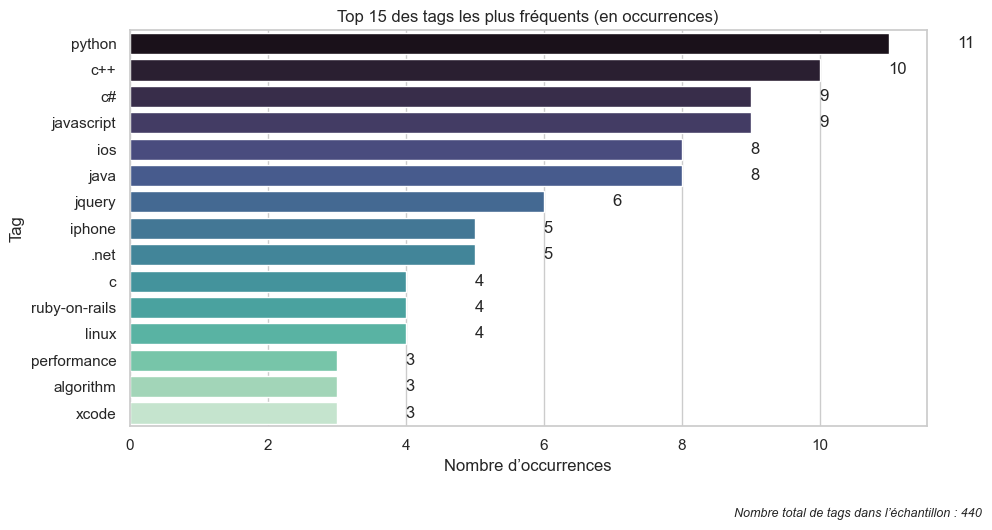

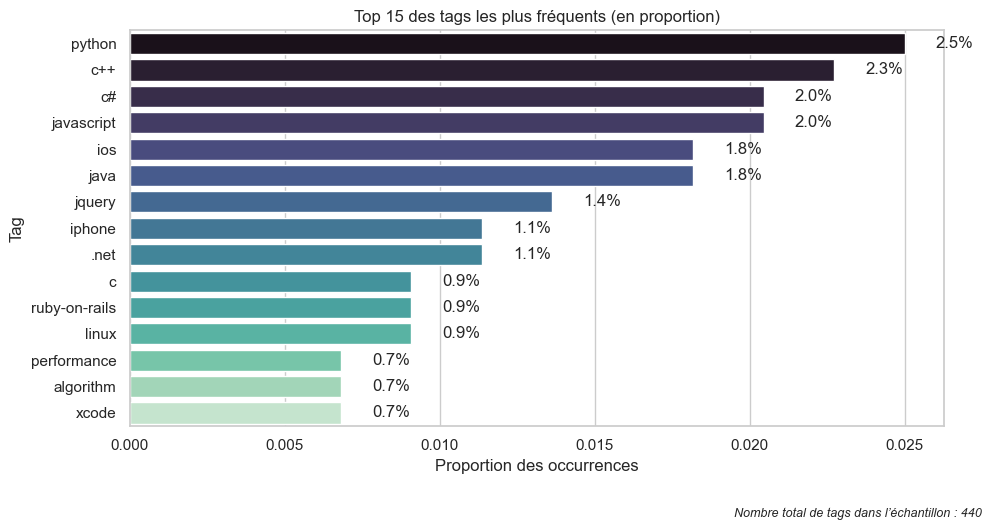

In [34]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# ------------------------------------------------------
# --- VERIFICATION ET CONVERSION DES TAGS SI NECESSAIRE
# ------------------------------------------------------
if isinstance(sample_explo_wo["Tags"].iloc[0], str):
    sample_explo_wo["Tags"] = sample_explo_wo["Tags"].apply(ast.literal_eval)
# -------------------------
# --- ENCODAGE MULTI-LABEL
# -------------------------
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(sample_explo_wo["Tags"])
# ---------------------------------
# --- CREATION DU DATAFRAME ENCODE
# ----------------------------------
tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)
print("# --- ON AFFICHE LES TAGS ENCODES")
display(tags_df)
# --------------------------------------------
# --- FUSION AVEC LE DATAFRAME sample_explo_wo
# ---------------------------------------------
sample_explo_wo = pd.concat([sample_explo_wo, tags_df], axis=1)
print("# --- ON AFFICHE LA FUSION DES TAGS ENCODES AVEC LE DATAFRAME sample_explo_wo : ")
display(sample_explo_wo)
# ----------------------------
# --- SAUVEGARDE DU BINARIZER
# -----------------------------
import os
import joblib
# 🔐 Création du dossier standardisé
os.makedirs("models/tags", exist_ok=True)
# 💾 Sauvegarde du binarizer
joblib.dump(mlb, "models/tags/multilabel_binarizer_sample.pkl")
np.save("models/tags/y_tags.npy", tags_encoded)



# --- VISUALISATION 
tag_counts = tags_df.sum().sort_values(ascending=False)
tag_freq_df = tag_counts.reset_index()
tag_freq_df.columns = ["Tag", "Count"]
eda.plot_tag_occurrences(tag_freq_df, top_n=15, palette="mako")
eda.plot_tag_distribution(tag_freq_df, top_n=15, palette="mako")


### 4.2. APPLICATION SUR 50 K QUESTIONS

#### **4.2.1. VECTORISATION TF-IDF**

Shape de la matrice TF-IDF (title + body) : (9091, 6616)
Top 20 mots (title + body) par poids TF-IDF :
image: 124.21
datum: 123.75
user: 122.63
application: 117.25
app: 113.48
time: 111.10
android: 105.02
python: 104.03
server: 101.42
java: 101.20
text: 100.85
gt: 95.84
possible: 95.59
difference: 83.51
number: 83.05
em: 80.06
key: 77.14
javascript: 76.64
database: 75.51
web: 73.13


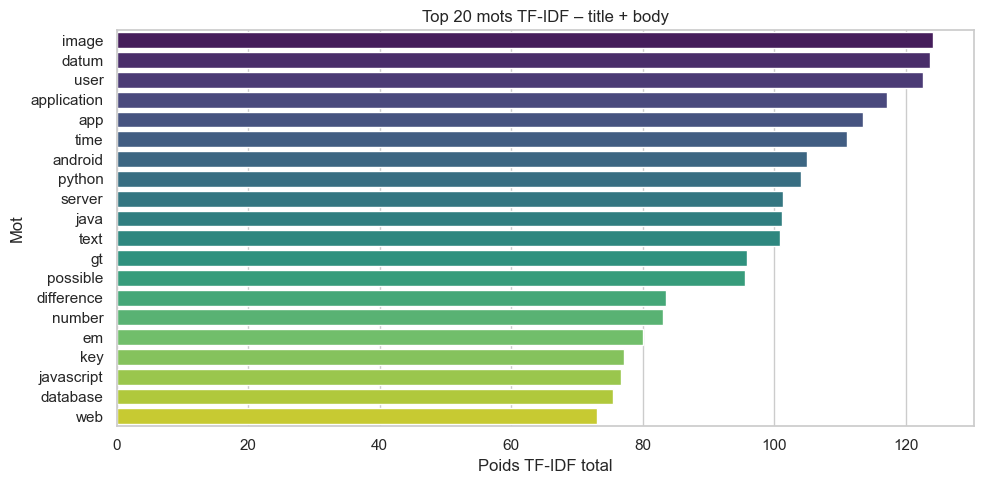

In [35]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

X_titlebody_tfidf_full, titlebody_vocab_full, top_titlebody_words_full = eda.vectorize_tfidf(
    full_explo_wo["clean_title_body"],
    label="title + body",
    max_features=10000,
    min_df=5,
    top_n=20,
    show_wordcloud=False  # Désactivé si tu veux préserver la RAM
)
from scipy.sparse import save_npz
import pickle

# 🔒 Sauvegarde de la matrice TF-IDF
save_npz("models/tfidf/X_tfidf_full.npz", X_titlebody_tfidf_full)

# 📦 Sauvegarde du vocabulaire
with open("models/tfidf/vocab_tfidf_full.pkl", "wb") as f:
    pickle.dump(titlebody_vocab_full, f)

with open("models/tfidf/top_titlebody_words_full.pkl", "wb") as f:
    pickle.dump(top_titlebody_words_full, f)

with open("models/tfidf/corpus_full.pkl", "wb") as f:
    pickle.dump(full_explo_wo["clean_title_body"].tolist(), f)

#### **4.2.2. REDUCTION DE DIMENSION (SVD, PCA)**

Explained variance (title + body) : 0.71%


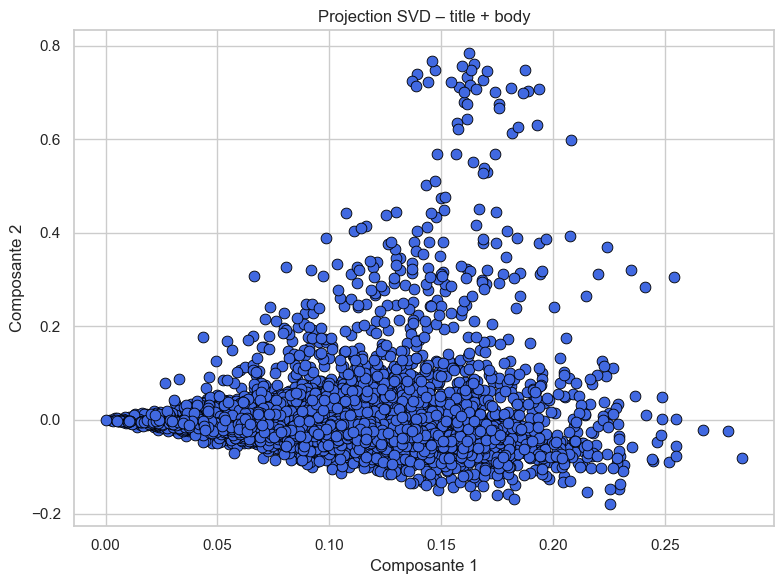

Variance expliquée cumulée (title + body) :
 - 10 composantes : 3.76%
 - 20 composantes : 6.66%
 - 50 composantes : 12.78%


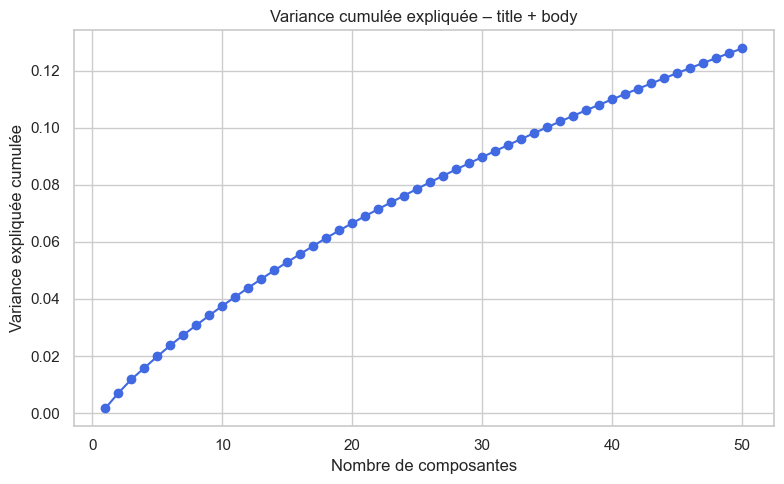

In [36]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

from scipy.sparse import load_npz

X_titlebody_tfidf_full = load_npz("models/tfidf/X_tfidf_full.npz")

# --- REDUCTION SVD POUR VISUALISATION 2D
X_titlebody_svd_full, svd_titlebody_full = eda.apply_svd_and_plot(
    X_titlebody_tfidf_full,
    label="title + body",
    n_components=2
)
# --- REDUCTION SVD POUR EXTRACTION DES FEATURES ET SAUVEGARDE EN .npy
X_titlebody_svd10k, svd_titlebody10k = eda.apply_svd_variance(
    X_titlebody_tfidf_full,
    label="title + body",
    n_components=50
)
import numpy as np
np.save("models/svd/X_titlebody_svd10k.npy", X_titlebody_svd10k)

import pickle
with open("models/svd/svd_model_10k.pkl", "wb") as f:
    pickle.dump(svd_titlebody10k, f)

#### **4.2.3. EMBEDDINGS**

##### 4.2.3.1. METHODE SBERT

In [37]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

corpus_titlebody_full = full_explo_wo["clean_title_body"].fillna("").tolist()
embeddings_sbert_full = eda.encode_sbert_corpus(corpus_titlebody_full, batch_size=32)
print(f"✅ SBERT Embeddings shape : {embeddings_sbert_full.shape}")
np.save("models/sbert/embeddings_sbert_full.npy", embeddings_sbert_full)

INFO - 2025-07-30 11:34:24,290 - Use pytorch device_name: cpu
INFO - 2025-07-30 11:34:24,290 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


🔄 Chargement du modèle SBERT...
✅ SBERT chargé : all-MiniLM-L6-v2
➡️ Batch 0 à 32 encodé
➡️ Batch 32 à 64 encodé
➡️ Batch 64 à 96 encodé
➡️ Batch 96 à 128 encodé
➡️ Batch 128 à 160 encodé
➡️ Batch 160 à 192 encodé
➡️ Batch 192 à 224 encodé
➡️ Batch 224 à 256 encodé
➡️ Batch 256 à 288 encodé
➡️ Batch 288 à 320 encodé
➡️ Batch 320 à 352 encodé
➡️ Batch 352 à 384 encodé
➡️ Batch 384 à 416 encodé
➡️ Batch 416 à 448 encodé
➡️ Batch 448 à 480 encodé
➡️ Batch 480 à 512 encodé
➡️ Batch 512 à 544 encodé
➡️ Batch 544 à 576 encodé
➡️ Batch 576 à 608 encodé
➡️ Batch 608 à 640 encodé
➡️ Batch 640 à 672 encodé
➡️ Batch 672 à 704 encodé
➡️ Batch 704 à 736 encodé
➡️ Batch 736 à 768 encodé
➡️ Batch 768 à 800 encodé
➡️ Batch 800 à 832 encodé
➡️ Batch 832 à 864 encodé
➡️ Batch 864 à 896 encodé
➡️ Batch 896 à 928 encodé
➡️ Batch 928 à 960 encodé
➡️ Batch 960 à 992 encodé
➡️ Batch 992 à 1024 encodé
➡️ Batch 1024 à 1056 encodé
➡️ Batch 1056 à 1088 encodé
➡️ Batch 1088 à 1120 encodé
➡️ Batch 1120 à 1152 enco

##### 4.2.3.2. METHODE WORD2VEC

In [38]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)
from gensim.models import Word2Vec

corpus_titlebody_full = full_explo_wo["clean_title_body"].fillna("").tolist()

model_w2v_full = eda.train_word2vec(
    corpus=corpus_titlebody_full,
    save_path="models/word2vec/word2vec_titlebody_full.bin",  # dossier à créer si nécessaire
    vector_size=100,
    window=5,
    min_count=3,
    epochs=10,
    verbose=True
)
# 🔁 Vectorisation du corpus complet
w2v_model_full = Word2Vec.load("models/word2vec/word2vec_titlebody_full.bin")
# corpus_full = full_df["clean_title_body"].fillna("").tolist()
X_w2v_full = eda.vectorize_texts(corpus_titlebody_full, w2v_model_full)

# 💾 Sauvegarde
np.save("models/word2vec/X_w2v_full.npy", X_w2v_full)

🔄 Préparation du corpus...
🧠 Corpus prêt avec 9091 documents.


INFO - 2025-07-30 11:41:46,106 - collecting all words and their counts
INFO - 2025-07-30 11:41:46,161 - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2025-07-30 11:41:46,255 - collected 23710 word types from a corpus of 291444 raw words and 9091 sentences
INFO - 2025-07-30 11:41:46,255 - Creating a fresh vocabulary
INFO - 2025-07-30 11:41:46,456 - Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 8714 unique words (36.75% of original 23710, drops 14996)', 'datetime': '2025-07-30T11:41:46.439459', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
INFO - 2025-07-30 11:41:46,472 - Word2Vec lifecycle event {'msg': 'effective_min_count=3 leaves 272443 word corpus (93.48% of original 291444, drops 19001)', 'datetime': '2025-07-30T11:41:46.472760', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:0

💾 Modèle sauvegardé dans d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\notebooks\models\word2vec\word2vec_titlebody_full.bin


INFO - 2025-07-30 11:42:07,822 - loading wv recursively from models/word2vec/word2vec_titlebody_full.bin.wv.* with mmap=None
INFO - 2025-07-30 11:42:07,822 - setting ignored attribute cum_table to None
INFO - 2025-07-30 11:42:07,938 - Word2Vec lifecycle event {'fname': 'models/word2vec/word2vec_titlebody_full.bin', 'datetime': '2025-07-30T11:42:07.938300', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'loaded'}


##### 4.2.3.3. METHODE UNIVERSAL SENTENCE ENCODER (USE)

In [39]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)


corpus_titlebody_full = full_explo_wo["clean_title_body"].fillna("").tolist()

embeddings_use_full = eda.encode_use_corpus(corpus_titlebody_full, batch_size=100)
print(f"✅ USE Embeddings shape : {embeddings_use_full.shape}")
np.save("models/use_model/embeddings_use_full.npy", embeddings_use_full)

INFO - 2025-07-30 11:43:45,101 - Fingerprint not found. Saved model loading will continue.
INFO - 2025-07-30 11:43:45,484 - path_and_singleprint metric could not be logged. Saved model loading will continue.


✅ USE chargé depuis : C:\Users\hp\.cache\kagglehub\models\google\universal-sentence-encoder\tensorFlow2\universal-sentence-encoder\2
🔄 Batch 0 → 100 encodé
🔄 Batch 100 → 200 encodé
🔄 Batch 200 → 300 encodé
🔄 Batch 300 → 400 encodé
🔄 Batch 400 → 500 encodé
🔄 Batch 500 → 600 encodé
🔄 Batch 600 → 700 encodé
🔄 Batch 700 → 800 encodé
🔄 Batch 800 → 900 encodé
🔄 Batch 900 → 1000 encodé
🔄 Batch 1000 → 1100 encodé
🔄 Batch 1100 → 1200 encodé
🔄 Batch 1200 → 1300 encodé
🔄 Batch 1300 → 1400 encodé
🔄 Batch 1400 → 1500 encodé
🔄 Batch 1500 → 1600 encodé
🔄 Batch 1600 → 1700 encodé
🔄 Batch 1700 → 1800 encodé
🔄 Batch 1800 → 1900 encodé
🔄 Batch 1900 → 2000 encodé
🔄 Batch 2000 → 2100 encodé
🔄 Batch 2100 → 2200 encodé
🔄 Batch 2200 → 2300 encodé
🔄 Batch 2300 → 2400 encodé
🔄 Batch 2400 → 2500 encodé
🔄 Batch 2500 → 2600 encodé
🔄 Batch 2600 → 2700 encodé
🔄 Batch 2700 → 2800 encodé
🔄 Batch 2800 → 2900 encodé
🔄 Batch 2900 → 3000 encodé
🔄 Batch 3000 → 3100 encodé
🔄 Batch 3100 → 3200 encodé
🔄 Batch 3200 → 3300 enco

#### **4.2.4. VECTORISATION BoW (CountVectorizer)**

In [40]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

corpus_bow_full, X_bow_full, vocab_bow_full = eda.build_bow_matrix(
    df=full_explo_wo,
    col_title="clean_title_body",  # ✅ corpus fusionné
    col_body="clean_title_body",  # ✅ encore le même
    max_df=0.9,
    min_df=5,
    stop_words="english"
)

print("# --- Matrice BoW:", X_bow_full.shape)
print("# --- Taille du vocabulaire:", len(vocab_bow_full))
import scipy.sparse
scipy.sparse.save_npz("models/bow/X_bow_full.npz", X_bow_full)
import pickle
with open("models/bow/corpus_bow_full.pkl", "wb") as f:
    pickle.dump(corpus_bow_full, f)
with open("models/bow/vocab_bow_full.pkl", "wb") as f:
    pickle.dump(vocab_bow_full, f)


# --- Matrice BoW: (9091, 3964)
# --- Taille du vocabulaire: 3964


#### **4.2.5. ENCODAGE DES TAGS (MULTI-LABEL BINARIZER)**

Shape du matrix multi-label : (9091, 7259)


,.doc,.hgtags,.htaccess,.lib,.net,.net-1.1,.net-2.0,.net-3.5,.net-4.0,.net-4.5,...,zombie-process,zombie.js,zooming,zope,zpt,zsh,zsh-completion,zshrc,zurb-foundation,zxing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\hp\AppData\Local\Temp\ipykernel_17652\3098107200.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tag_freq_df.head(15), x="Count", y="Tag", palette="mako")


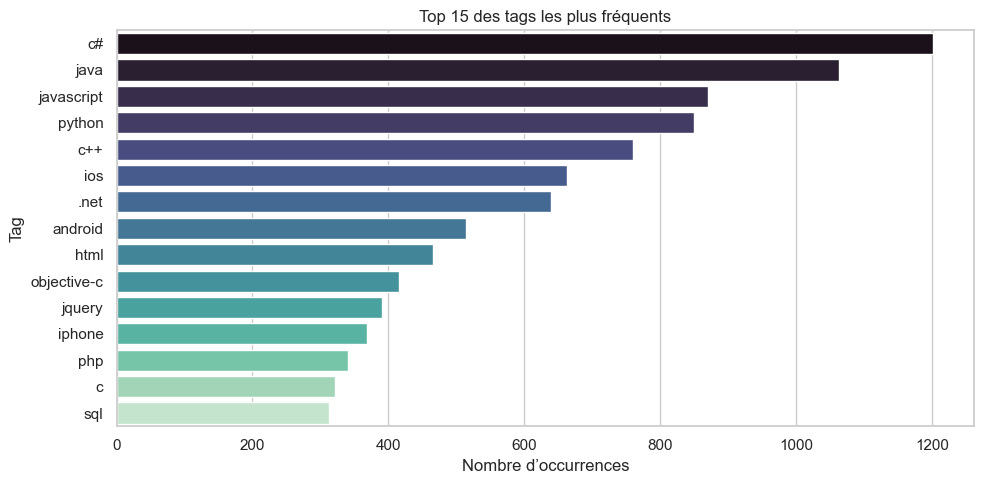

In [41]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

import ast
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# 🔍 Vérification des tags
# --------------------------
if isinstance(full_explo_wo["Tags"].iloc[0], str):
    full_explo_wo["Tags"] = full_explo_wo["Tags"].apply(ast.literal_eval)

# ---------------------------
# 🧠 Encodage multilabel
# ---------------------------
mlb_full = MultiLabelBinarizer()
tags_encoded_full = mlb_full.fit_transform(full_explo_wo["Tags"])

# ✅ DataFrame des tags encodés
tags_df_full = pd.DataFrame(tags_encoded_full, columns=mlb_full.classes_)
print(f"Shape du matrix multi-label : {tags_encoded_full.shape}")
display(tags_df_full.head())

# -----------------------------------
# 🔗 Fusion avec full_explo_wo
# -----------------------------------
full_explo_wo = pd.concat([full_explo_wo, tags_df_full], axis=1)

# ---------------------------------------------
# 💾 Sauvegarde du binarizer + vecteur encodé
# ---------------------------------------------
os.makedirs("models/tags", exist_ok=True)
np.save("models/tags/y_tags_full.npy", tags_encoded_full)
joblib.dump(mlb_full, "models/tags/multilabel_binarizer_full.pkl")

# ---------------------------------------------
# 📊 Visualisation des tags les plus fréquents
# ---------------------------------------------
tag_counts = tags_df_full.sum().sort_values(ascending=False)
tag_freq_df = tag_counts.reset_index()
tag_freq_df.columns = ["Tag", "Count"]

# --- Barplot (Top 15 Tags)
plt.figure(figsize=(10, 5))
sns.barplot(data=tag_freq_df.head(15), x="Count", y="Tag", palette="mako")
plt.title("Top 15 des tags les plus fréquents")
plt.xlabel("Nombre d’occurrences")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()


## **5. EXPORT**

### 5.1. APPLICATION SUR UN ECHANTILLON DE 100 QUESTIONS

Les artefacts `corpus`, `X_bow` et `vocab` ayant été créés dans la section précédente dédiée à la vectorisation Bag-of-Words, ils sont ici uniquement exportés pour être utilisés dans le notebook `3_modele_non_supervise_lda.ipynb` (modélisation LDA).

Aucun recalcul n’est effectué ici afin de garantir la modularité du pipeline.


In [42]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)



print(f"Dimensions du dataframe sample_df : {sample_explo_wo.shape}")
print(f" Colonnes du dataframe sample_df : {sample_explo_wo.columns.tolist()}")
print(f"Dimensions du dataframe full_df : {full_explo_wo.shape}")
print(f" Colonnes du dataframe full_df : {full_explo_wo.columns.tolist()}")

# ---------------------------------
# --- CREATION DU DOSSIER D'EXPORT
# ---------------------------------
os.makedirs("../data/processed", exist_ok=True)
# ------------------------------------------------------------
# --- EXPORT DES DATAFRAMES NETTOYES SANS OUTLIERS ET EXPLORES
# -------------------------------------------------------------
# 💾 sample_explo_wo (100 questions sans outliers)
sample_explo_wo.to_parquet("data/processed/sample_explo_wo.parquet", index=False)

# 💾 full_explo_wo (10k questions sans outliers)
full_explo_wo.to_parquet("data/processed/full_explo_wo.parquet", index=False)



Dimensions du dataframe sample_df : (88, 327)
 Colonnes du dataframe sample_df : ['PostId', 'Title', 'Body', 'Score', 'ViewCount', 'AnswerCount', 'CreationDate', 'TagCount', 'Tags', 'clean_title_body', 'title_body_length_char', 'title_body_length_words', 'is_outlier', '.net', '.net-4.0', '64-bit', 'addsubview', 'algorithm', 'android', 'angularjs', 'anonymous-class', 'arrays', 'asp.net-4.0', 'asp.net-mvc', 'asp.net-mvc-3', 'associative-array', 'atomic', 'attributeerror', 'authentication', 'authorization', 'auto-vectorization', 'background', 'backwards-compatibility', 'bacon.js', 'baud-rate', 'bcrypt', 'beautifulsoup', 'between', 'binary-search-tree', 'bind', 'bitrate', 'blueprint-css', 'boolean-logic', 'c', 'c#', 'c#-3.0', 'c++', 'c++11', 'c11', 'caching', 'camera', 'caret', 'carousel', 'celery', 'centos', 'checkbox', 'circular-dependency', 'cocoa', 'cocoa-touch', 'com', 'compass-sass', 'compilation', 'components', 'computer-vision', 'constructor', 'contenteditable', 'criteria', 'crypt'

### 5.2. EXPORT SUR 50 K QUESTIONS

Cette sous-section permet de sauvegarder tous les artefacts NLP construits sur le corpus complet (`brut_df`) afin de les rendre accessibles aux notebooks suivants :  
`3_modele_non_supervise_lda.ipynb`, `4_modele_supervise_mlflow.ipynb`, etc.



***Corpus exporté :***

| Nom | Format | Description |
|-----|--------|-------------|
| `corpus_for_lda.csv` | CSV | Texte nettoyé (titre + body concaténé) avec `PostId` |
| `corpus_for_lda_bow.pkl` | PKL | Matrice BoW pour modélisation LDA |
| `corpus_for_lda_vocab.pkl` | PKL | Vocabulaire associé à la BoW |
| `tfidf_matrix_concat.pkl` | PKL | Matrice TF-IDF des 50k questions |
| `tfidf_vocab_concat.pkl` | PKL | Vocabulaire TF-IDF (concaténé) |
| `dominant_tags_brut.pkl` | PKL | Liste des tags dominants repérés sur `brut_df` |
| `multilabel_binarizer.pkl` | PKL | Encodeur des tags multi-label (sklearn) |
| `tags_encoded_brut.pkl` | PKL | Matrice Y cible (multi-label) pour modèle supervisé |



Ces artefacts sont réutilisables sans recalcul dans tous les notebooks de modélisation, et peuvent être versionnés pour suivre l’évolution du pipeline.

Cette étape garantit la modularité du projet et son passage en production.


## ANNEXE 

### A.1. Nomenclature des DataFrames utilisés

| Nom du DataFrame       | Description |
|------------------------|-------------|
| `brut_df`              | Données brutes chargées depuis le fichier CSV |
| `sample_df`            | Échantillon de 100 questions tiré de `brut_df` |
| `sample_clean`         | Version nettoyée de `sample_df` (après prétraitement) |
| `sample_explo`         | Copie de travail pour l’exploration (à partir de `sample_clean`) |
| `sample_explo_wo`      | Version de `sample_explo` sans outliers (`wo = without outliers`) |
| `sample_outliers`      | Sous-ensemble de `sample_explo` contenant uniquement les outliers |
| `full_clean`           | Données complètes nettoyées (lors de la mise à l’échelle) |
| `full_explo`           | Copie de travail pour l’exploration complète |
| `full_explo_wo`        | Version sans outliers du corpus complet |


### A.2. RAPPELS DES NOTIONS IMPLIQUEES DANS LE FEATURE ENGINEERING EN NLP

Cette annexe vise à expliciter les concepts mathématiques et vectoriels sous-jacents aux principales étapes de transformation des textes dans le cadre du NLP. Elle s’adresse à un lecteur ayant une formation scientifique avancée.



#### A.2.1. Vecteurs creux vs. vecteurs denses

- Un **vecteur creux** (sparse vector) est un vecteur dont la majorité des composantes sont nulles.
  - Exemple : `[0, 0, 0.5, 0, 0, 0.3, 0, 0, 0, 0.2]`
  - Typique des représentations TF-IDF : chaque document n’utilise qu’un petit sous-ensemble du vocabulaire.

- Un **vecteur dense** est un vecteur dont la plupart des composantes sont non nulles.
  - Exemple : `[0.12, -0.03, 0.45, 0.08, -0.22, 0.19]`
  - Typique des embeddings ou des vecteurs après réduction de dimension.



#### A.2.2. Variables latentes et espace latent

- Une **variable latente** est une variable non observée directement, mais déduite à partir des données.
- En NLP, les **axes latents** correspondent à des thématiques ou structures cachées dans les textes.
- L’**espace latent** est un espace vectoriel réduit, où chaque dimension représente une composante thématique implicite.



#### A.2.3. Base canonique vs. base sémantique

- La **base canonique** est formée par les mots du vocabulaire : chaque mot est une dimension orthogonale.
- Elle est arbitraire, très grande, et souvent redondante.
- Une **base sémantique** est une base apprise ou extraite (via SVD ou embeddings) où chaque dimension reflète un thème ou une proximité de sens.
- Elle est plus compacte, plus informative, mais non orthogonale.



#### A.2.4. Décomposition SVD (Singular Value Decomposition)  

Soit une matrice TF-IDF X de taille (m × n), où :

- m est le nombre de documents
- n est la taille du vocabulaire (nombre de mots uniques)
- Chaque ligne de X est un vecteur TF-IDF représentant un document

La décomposition en valeurs singulières (SVD) permet d’écrire :

X = U × Σ × Vᵗ

avec :

- U ∈ ℝ^(m × r) : matrice des vecteurs propres des documents (orthogonaux)
- Σ ∈ ℝ^(r × r) : matrice diagonale contenant les valeurs singulières décroissantes
- V ∈ ℝ^(n × r) : matrice des vecteurs propres des mots (orthogonaux)

où r est le rang de X (r ≤ min(m, n))


**Réduction de dimension**

En pratique, on ne conserve que les k premières composantes (avec k ≪ r), ce qui donne une approximation de rang k :

X ≈ U_k × Σ_k × V_kᵗ

avec :

- U_k ∈ ℝ^(m × k) : projection des documents dans un espace latent de dimension k
- Σ_k ∈ ℝ^(k × k) : valeurs singulières principales
- V_k ∈ ℝ^(n × k) : projection des mots dans le même espace latent


**Interprétation**

- Chaque document est représenté par un vecteur dense de dimension k, capturant ses composantes thématiques latentes
- Chaque mot est également projeté dans cet espace, révélant ses affinités sémantiques
- Les valeurs singulières indiquent l’importance relative de chaque axe latent

**Utilité en NLP**

- Réduction de dimension : compresser les vecteurs TF-IDF très grands et creux
- Suppression du bruit lexical : éliminer les dimensions peu informatives
- Découverte de thématiques : chaque axe latent peut être interprété comme un thème sémantique

Cette technique est à la base de la méthode LSA (Latent Semantic Analysis).

#### A.2.5. Embeddings (Word2Vec, FastText, BERT…)

- Les **embeddings** sont des vecteurs denses appris par des modèles de langage.
- Ils sont construits pour que les mots ayant des contextes similaires aient des vecteurs proches.
- Contrairement à TF-IDF, ils capturent :
  - La **sémantique** (proximité de sens)
  - Le **contexte** (dans les modèles comme BERT)
  - Les **relations syntaxiques** et **logiques**

Exemple d’analogie vectorielle :  
`king - man + woman ≈ queen`

Mathématiquement, les embeddings sont issus d’une **factorisation implicite** de la matrice de co-occurrence des mots, ou d’un apprentissage supervisé/non supervisé sur des tâches de prédiction de contexte.



#### A.2.6. Encodage des tags – MultiLabelBinarizer

- Les tags sont des cibles multi-label (un document peut avoir plusieurs étiquettes).
- Le **MultiLabelBinarizer** transforme chaque liste de tags en un vecteur binaire.

Exemple :

| Tags | Encodage |
|------|----------|
| ['python', 'django'] | [1, 0, 1, 0, …] |

Chaque dimension correspond à un tag unique.  
Ce format est requis pour entraîner un modèle de classification multi-label.



#### A.2.7. Résumé global du pipeline vectoriel

| Étape | Entrée | Sortie | Objectif |
|-------|--------|--------|----------|
| TF-IDF | Texte brut | Vecteurs creux | Pondérer les mots |
| SVD / PCA | TF-IDF | Vecteurs denses réduits | Capturer les axes thématiques |
| Embeddings | Texte brut | Vecteurs denses sémantiques | Capturer le sens |
| MultiLabelBinarizer | Tags | Vecteurs binaires (cibles) | Préparer les cibles |

---


### A.3. FONCTIONNEMENT DE FASTAPI

```text
+-------------------------------+
|        Client (UI,           |
|   script Python, Swagger)    |
+---------------+---------------+
                |
                |  POST /embed/sbert
                |  { "text": "..." }
                v
+---------------+---------------+
|         FastAPI App           |
|     (src/api/main.py)         |
+---------------+---------------+
                |
                v
+---------------+---------------+
|  Route /embed/sbert           |
|  (embed_routes.py)            |
|  - Valide l'entrée (pydantic) |
|  - Appelle encode_with_sbert  |
+---------------+---------------+
                |
                v
+---------------+---------------+
|  SBERT Model (sbert_model.py) |
+---------------+---------------+
                |
                v
+---------------+---------------+
|  Embedding vector (list)      |
|  ex: [0.123, -0.456, ...]     |
+---------------+---------------+
                |
                v
+-------------------------------+
|   JSON Response to Client     |
|   { "embedding": [...] }      |
+-------------------------------+


### A.4. MISE A L'ECHELLE

Ce notebook a été développé sur `sample_df` pour valider les fonctions de nettoyage, d’analyse exploratoire et de construction des features textuelles.

***Objectif à l’échelle : prétraiter les 50 000 questions StackOverflow extraites via SQL.***

| Étape | Action | Détails |
|-------|--------|---------|
|  Chargement des données brutes | Import du `brut_df` (50 000 questions) | Format : `.csv` ou SQL → colonnes `Title`, `Body`, `Tags`, etc. |
|  Nettoyage des textes | Application des fonctions `clean_title`, `clean_body` | Nettoyage HTML, ponctuation, contractions, stopwords |
|  Fusion des colonnes | Création de `clean_title_body` | Pour vectorisations futures (BoW, TF-IDF, embeddings) |
|  Suppression des doublons exacts | `df.duplicated(["Title", "Body"])` | Élimination des doublons 1:1 |
|  Filtrage d’outliers lexicaux | Longueur minimale des titres/corps | Exemple : `len(title) > 10` ou `nb_mots > 3` |
|  Analyse optionnelle | Stats descriptives & distribution de longueur | Permet de valider la structure du corpus brut |
|  Export des artefacts | Sauvegarde du corpus nettoyé dans `/data/processed/` | `brut_df_cleaned.csv` ou `.pkl` |

 Cette étape garantit que l’ensemble du corpus est prêt pour la modélisation à grande échelle.


Ce notebook a été conçu pour valider les étapes de prétraitement NLP sur un échantillon réduit (`sample_df`, 100 questions).  
La mise à l’échelle sur le corpus complet (`brut_df`, 50 000 questions) est structurée de manière parallèle, chaque sous-section étant dupliquée pour assurer cohérence et industrialisation.

---

***Structure de Mise à l’Échelle par Bloc***

| Section originale | Sous-section à créer pour `brut_df` | Objectif |
|------------------|--------------------------------------|----------|
| `2.1. Nettoyage - sample_df` | `2.2. Nettoyage - brut_df` | Nettoyer les 50k titres et corps via `clean_text_spacy_custom()` |
| `3.1. Exploration - sample_explo` | `3.2. Exploration - full_explo` | Calculer longueurs, ratios, distributions sur tout le corpus |
| `3.1.4 Détection des doublons/outliers - sample_df` | `3.2.4 Détection - brut_df` | Exclure les lignes bruitées avant vectorisation |
| `3.1.5 Analyse des tags - sample_df` | `3.2.5 Analyse des tags - brut_df` | Étudier la diversité et marquer les tags dominants sur 50k |
| `3.1.6 Co-occurrence des tags` | `3.2.6 Co-occurrence des tags - brut_df` | Identifier clusters thématiques globaux |
| `4.1.1 Vectorisation TF-IDF - sample_df` | `4.2.1 Vectorisation TF-IDF - brut_df` | Générer les vecteurs `X_titlebody_tfidf_brut.pkl` |
| `4.1.4 Vectorisation BoW - sample_df` | `4.2.4 Vectorisation BoW - brut_df` | Générer `X_bow_brut.pkl` pour LDA |
| `4.1.5 Encodage des tags - sample_df` | `4.2.5 Encodage des tags - brut_df` | Générer la matrice cible multi-label `tags_encoded_brut.pkl` |
| `5. Export - sample_df` | `5. Export - brut_df` | Sauvegarde des artefacts TF-IDF, BoW, corpus nettoyé, vocabulaire |

---

***Artefacts à générer pour mise à l’échelle***

| Type | Nom suggéré | Format |
|------|-------------|--------|
| Corpus nettoyé complet | `corpus_cleaned_brut.csv` | CSV |
| Matrice BoW | `corpus_for_lda_bow_brut.pkl` | PKL |
| Vocabulaire BoW | `corpus_for_lda_vocab_brut.pkl` | PKL |
| Matrice TF-IDF | `tfidf_matrix_concat_brut.pkl` | PKL |
| Vocab TF-IDF | `tfidf_vocab_concat_brut.pkl` | PKL |
| Binarizer tags | `multilabel_binarizer_brut.pkl` | PKL |
| Matrice tags encodés | `tags_encoded_brut.pkl` | PKL |



***Recommandations***

- Utiliser le flag `use_sample=True/False` dans les fonctions du module `eda_analysis.py` pour switcher d’un jeu à l’autre.
- Surveiller la mémoire lors de l’utilisation d’embeddings ou de réductions de dimension : lancer par batch si nécessaire.
- Documenter chaque sous-section `brut_df` avec la mention :  
  *"Cette sous-section applique la logique validée sur `sample_df` au corpus complet de 50k questions (`brut_df`)."*



Ce plan permet une industrialisation progressive et structurée du pipeline, tout en conservant la rigueur d’exploration testée sur l’échantillon.



In [43]:
# import kagglehub
# path = kagglehub.model_download("google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder")
# print("✅ Modèle téléchargé dans :", path)
